# *** NOTEBOOK CONNECTED TO AWS ****

# CLIENT: INSTACART

In [658]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas import DataFrame

Observed Biases
* number of orders per customers = 4-100
* days since prior order = 30 cap

In [2]:
df = pd.read_csv('order_breakdown.csv',na_values=['NULL'])

In [700]:
orders_df = pd.read_csv('orders.csv',na_values=['NULL'])

In [701]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,nan%
1,2398795,1,prior,2,3,7,15.00%
2,473747,1,prior,3,3,12,21.00%
3,2254736,1,prior,4,4,7,29.00%
4,431534,1,prior,5,4,15,28.00%


In [702]:
# Do any data types need to be updated? No
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
aisle_id                  int64
department_id             int64
product_id                int64
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
add_to_cart_order         int64
reordered                 int64
product_name              object
department                object
aisle                     object
dtypes: float64(1), int64(10), object(4)
memory usage: 3.8+ GB


In [7]:
df.head()

,aisle_id,department_id,product_id,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,department,aisle
0,89,13,37371,114,91891,prior,1,0,11,NaN,3,0,Homestyle Ranch,pantry,salad dressing toppings
1,91,16,9036,488,127848,prior,22,1,19,4.0,2,1,Unsweetened Vanilla Cashew Milk,dairy eggs,soy lactosefree
2,91,16,24838,488,127848,prior,22,1,19,4.0,6,1,Unsweetened Almondmilk,dairy eggs,soy lactosefree
3,116,1,43647,683,152537,prior,3,0,15,30.0,6,0,Organic Asparagus Spears,frozen,frozen produce
4,67,20,21986,733,62760,prior,3,5,21,13.0,1,1,Artichoke Parmesan Dip,deli,fresh dips tapenades


In [8]:
#which columns have nulls? Only days_since_prior_order

df.isnull().sum()

aisle_id                        0
department_id                   0
product_id                      0
order_id                        0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
add_to_cart_order               0
reordered                       0
product_name                    0
department                      0
aisle                           0
dtype: int64

In [9]:
# order count
len(df['order_id'].unique())

3346083

In [10]:
# customer count
len(df['user_id'].unique())

206209

In [11]:
# product count
len(df['product_name'].unique())

49685

In [12]:
# department count
len(df['department_id'].unique())

21

In [13]:
# aisle count

len(df['aisle_id'].unique())

134

# EXPLORATORY DATA ANALYSIS - GENERAL

In [14]:
# all 134 aisles represented

df.aisle.value_counts()

fresh fruits                  3792661
fresh vegetables              3568630
packaged vegetables fruits    1843806
yogurt                        1507583
packaged cheese               1021462
                               ...   
eye ear care                     9522
baby bath body care              8909
baby accessories                 8466
beauty                           6455
frozen juice                     5147
Name: aisle, Length: 134, dtype: int64

In [15]:
# all departments are represented

df.department.value_counts()

produce            9888378
dairy eggs         5631067
snacks             3006412
beverages          2804175
frozen             2336858
pantry             1956819
bakery             1225181
canned goods       1114857
deli               1095540
dry goods pasta     905340
household           774652
meat seafood        739238
breakfast           739069
personal care       468693
babies              438743
international       281155
alcohol             159294
pets                102221
missing              77396
other                38086
bulk                 35932
Name: department, dtype: int64

In [703]:
# how many orders per day of the week?
 
orders_df.order_dow.value_counts()

0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: order_dow, dtype: int64

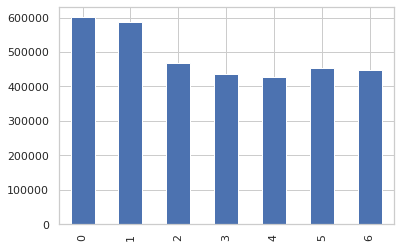

In [704]:
orders_df.order_dow.value_counts(sort=False).plot.bar()

Assumption: 0 & 1 are the weekend days and 2-6 are weekdays??

In [705]:
# how many orders per hour?

orders_df.order_hour_of_day.value_counts()

10    288418
11    284728
15    283639
14    283042
13    277999
12    272841
16    272553
9     257812
17    228795
18    182912
8     178201
19    140569
20    104292
7      91868
21     78109
22     61468
23     40043
6      30529
0      22758
1      12398
5       9569
2       7539
4       5527
3       5474
Name: order_hour_of_day, dtype: int64

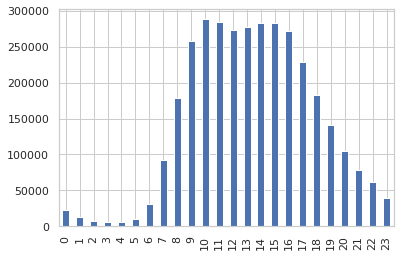

In [706]:
orders_df.order_hour_of_day.value_counts(sort=False).plot.bar()

Majority of orders are made during the day. Is there an Operations reason? Perhaps retailers are closed? or customer-driven?

Idea: create column, morning, afternoon, evening, postmidnight

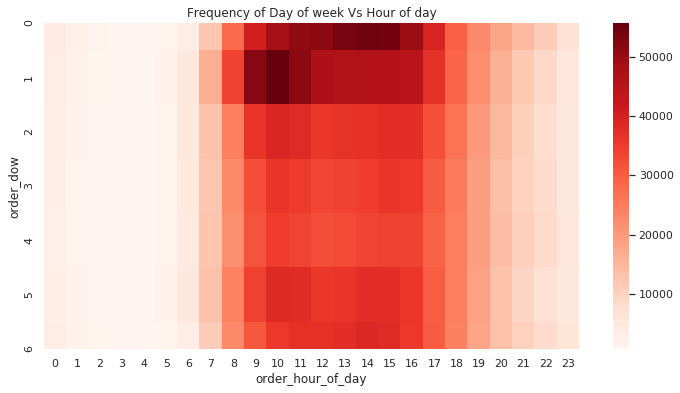

In [707]:
grouped_orders = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_orders = grouped_orders.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_orders, cmap="Reds")
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

when are orders more popular based on heat map? - Saturday 11AM - 4PM and Sunday 9Am to 12PM are most popular times to place orders

In [21]:
# Knowing df is an order breakdown based on products on each order, sum(reordered) / total = % reordered

df.reordered.sum() / df.shape[0]

0.5900617242809434

59% of products are reordered

Idea - What are the attributes of reordered products vs not?

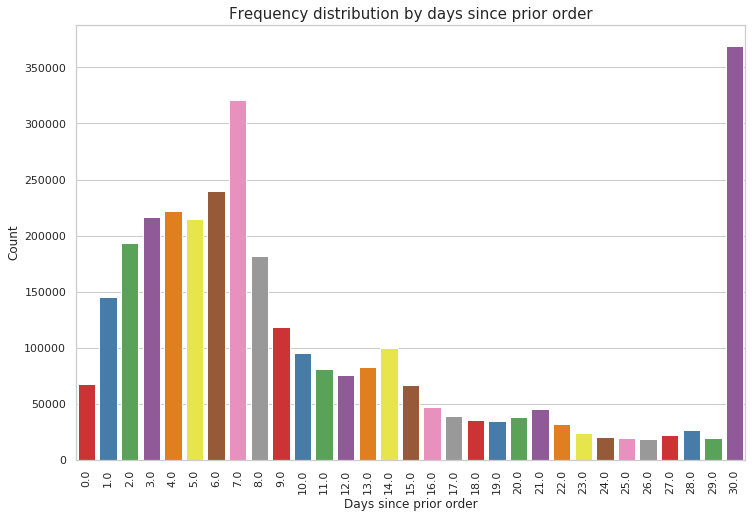

In [709]:
 # what is the distribution of orders by days since prior order?

plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, palette="Set1")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

30-days = cap
Ignoring cap, most orders are ordered 7 days from the last. Weekly Orders. 

Are these from the same customers? Are these mostly with reordered items? Are thses in the same say of the week?

In [710]:
orders_df.days_since_prior_order.value_counts()

30.00%    369323
7.00%     320608
6.00%     240013
4.00%     221696
3.00%     217005
5.00%     214503
2.00%     193206
8.00%     181717
1.00%     145247
9.00%     118188
14.00%    100230
10.00%     95186
13.00%     83214
11.00%     80970
12.00%     76146
0.00%      67755
15.00%     66579
16.00%     46941
21.00%     45470
17.00%     39245
20.00%     38527
18.00%     35881
19.00%     34384
22.00%     32012
28.00%     26777
23.00%     23885
27.00%     22013
24.00%     20712
25.00%     19234
29.00%     19191
26.00%     19016
Name: days_since_prior_order, dtype: int64

In [711]:
orders_df.count()

order_id                  3421083
user_id                   3421083
eval_set                  3421083
order_number              3421083
order_dow                 3421083
order_hour_of_day         3421083
days_since_prior_order    3214874
dtype: int64

In [25]:
# proportion of total orders with 7 days from last order
320608 / 3421083

0.09371535271140748

In [26]:
# orders with 0 reordered items

grouped_df = df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.881319
0    0.118681
Name: reordered, dtype: float64

11.8% of orders have 0 reordered items - Why?

In [162]:
# products per order

product_count = df['order_id'].value_counts()
product_count = pd.DataFrame(product_count).reset_index()
product_count.columns = ['order_id', 'product_count']

product_count = product_count['product_count'].value_counts(sort=False)
product_count = pd.DataFrame(product_count).reset_index()
product_count.columns = ['product_count', 'frequency']
product_count['percentage_of_total_orders'] = np.around(product_count['frequency'] / sum(product_count['frequency']), decimals=2)
product_count['cumulative_percentage_of_total_orders'] = np.cumsum(product_count['percentage_of_total_orders'])


In [163]:
type(product_count)

pandas.core.frame.DataFrame

In [164]:
pd.set_option('display.max_rows', None)

In [165]:
product_count

,product_count,frequency,percentage_of_total_orders,cumulative_percentage_of_total_orders
0,1,163593,0.05,0.05
1,2,194361,0.06,0.11
2,3,215060,0.06,0.17
3,4,230299,0.07,0.24
4,5,237225,0.07,0.31
5,6,236383,0.07,0.38
6,7,228547,0.07,0.45
7,8,211357,0.06,0.51
8,9,191564,0.06,0.57
9,10,172103,0.05,0.62


In [166]:
#record with max frequency
product_count[product_count['frequency']==product_count['frequency'].max()]

,product_count,frequency,percentage_of_total_orders,cumulative_percentage_of_total_orders
4,5,237225,0.07,0.31


In [167]:
type(product_count)

pandas.core.frame.DataFrame

Text(0.5, 1.0, 'Frequency - Product Count per Order')

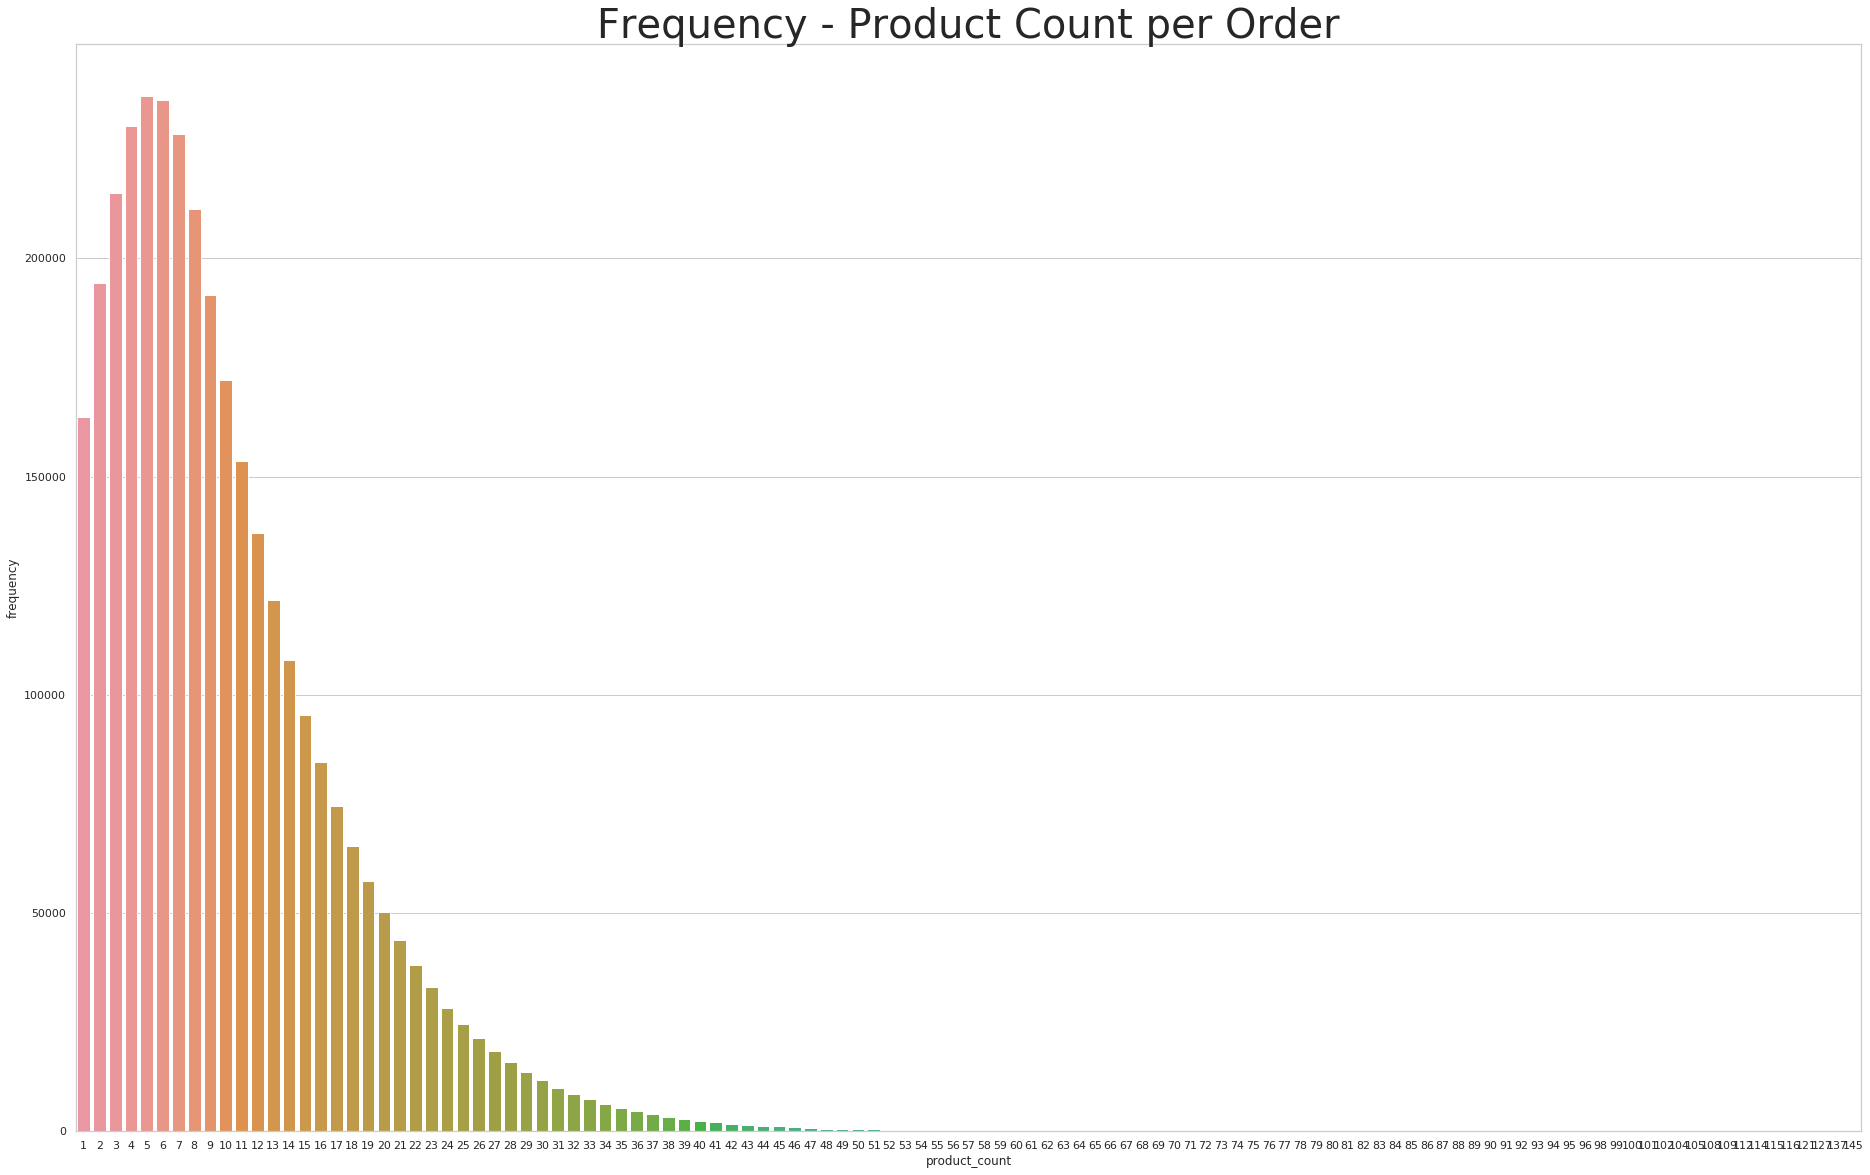

In [168]:
plt.figure(figsize=(32,20))
ax = sns.barplot(x='product_count', y='frequency', data=product_count)
plt.title('Frequency - Product Count per Order', fontsize=40)

The amount of products per order peaks at 5. 50% of orders have at least 8 products. 75% have at least 12. 24% have 3 or less.
How are we encouraging more products in one order?

In [114]:
user_order_count = df.groupby('user_id')['order_id'].nunique()
user_order_count = pd.DataFrame(user_order_count).reset_index()
user_order_count.columns = ['user_id', 'order_count']

user_order_count = user_order_count['order_count'].value_counts(sort=False)
user_order_count = pd.DataFrame(user_order_count).reset_index()
user_order_count.columns = ['order_count', 'frequency']
user_order_count['percentage_of_total_users'] = np.around(user_order_count['frequency'] / sum(user_order_count['frequency']),decimals=2)
user_order_count['cumulative_percentage_of_total_users'] = np.cumsum(user_order_count['percentage_of_total_users'])


In [115]:
type(user_order_count)

pandas.core.frame.DataFrame

In [116]:
user_order_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 4 columns):
order_count                             98 non-null int64
frequency                               98 non-null int64
percentage_of_total_users               98 non-null float64
cumulative_percentage_of_total_users    98 non-null float64
dtypes: float64(2), int64(2)
memory usage: 3.2 KB


In [117]:
user_order_count

,order_count,frequency,percentage_of_total_users,cumulative_percentage_of_total_users
0,3,8686,0.04,0.04
1,4,22451,0.11,0.15
2,5,18267,0.09,0.24
3,6,15334,0.07,0.31
4,7,13196,0.06,0.37
5,8,11075,0.05,0.42
6,9,9762,0.05,0.47
7,10,8660,0.04,0.51
8,11,7399,0.04,0.55
9,12,6787,0.03,0.58


In [133]:
user_order_count['order_count'].min()

3

In [132]:
user_order_count['order_count'].max()

100

In [129]:
#record with max frequency
user_order_count[user_order_count['frequency']==user_order_count['frequency'].max()]

,order_count,frequency,percentage_of_total_users,cumulative_percentage_of_total_users
1,4,22451,0.11,0.15


In [107]:
# confirm number of customers correct
user_order_count['frequency'].sum()==len(df['user_id'].unique())

True

Text(0.5, 1.0, 'Frequency - Order Count per User')

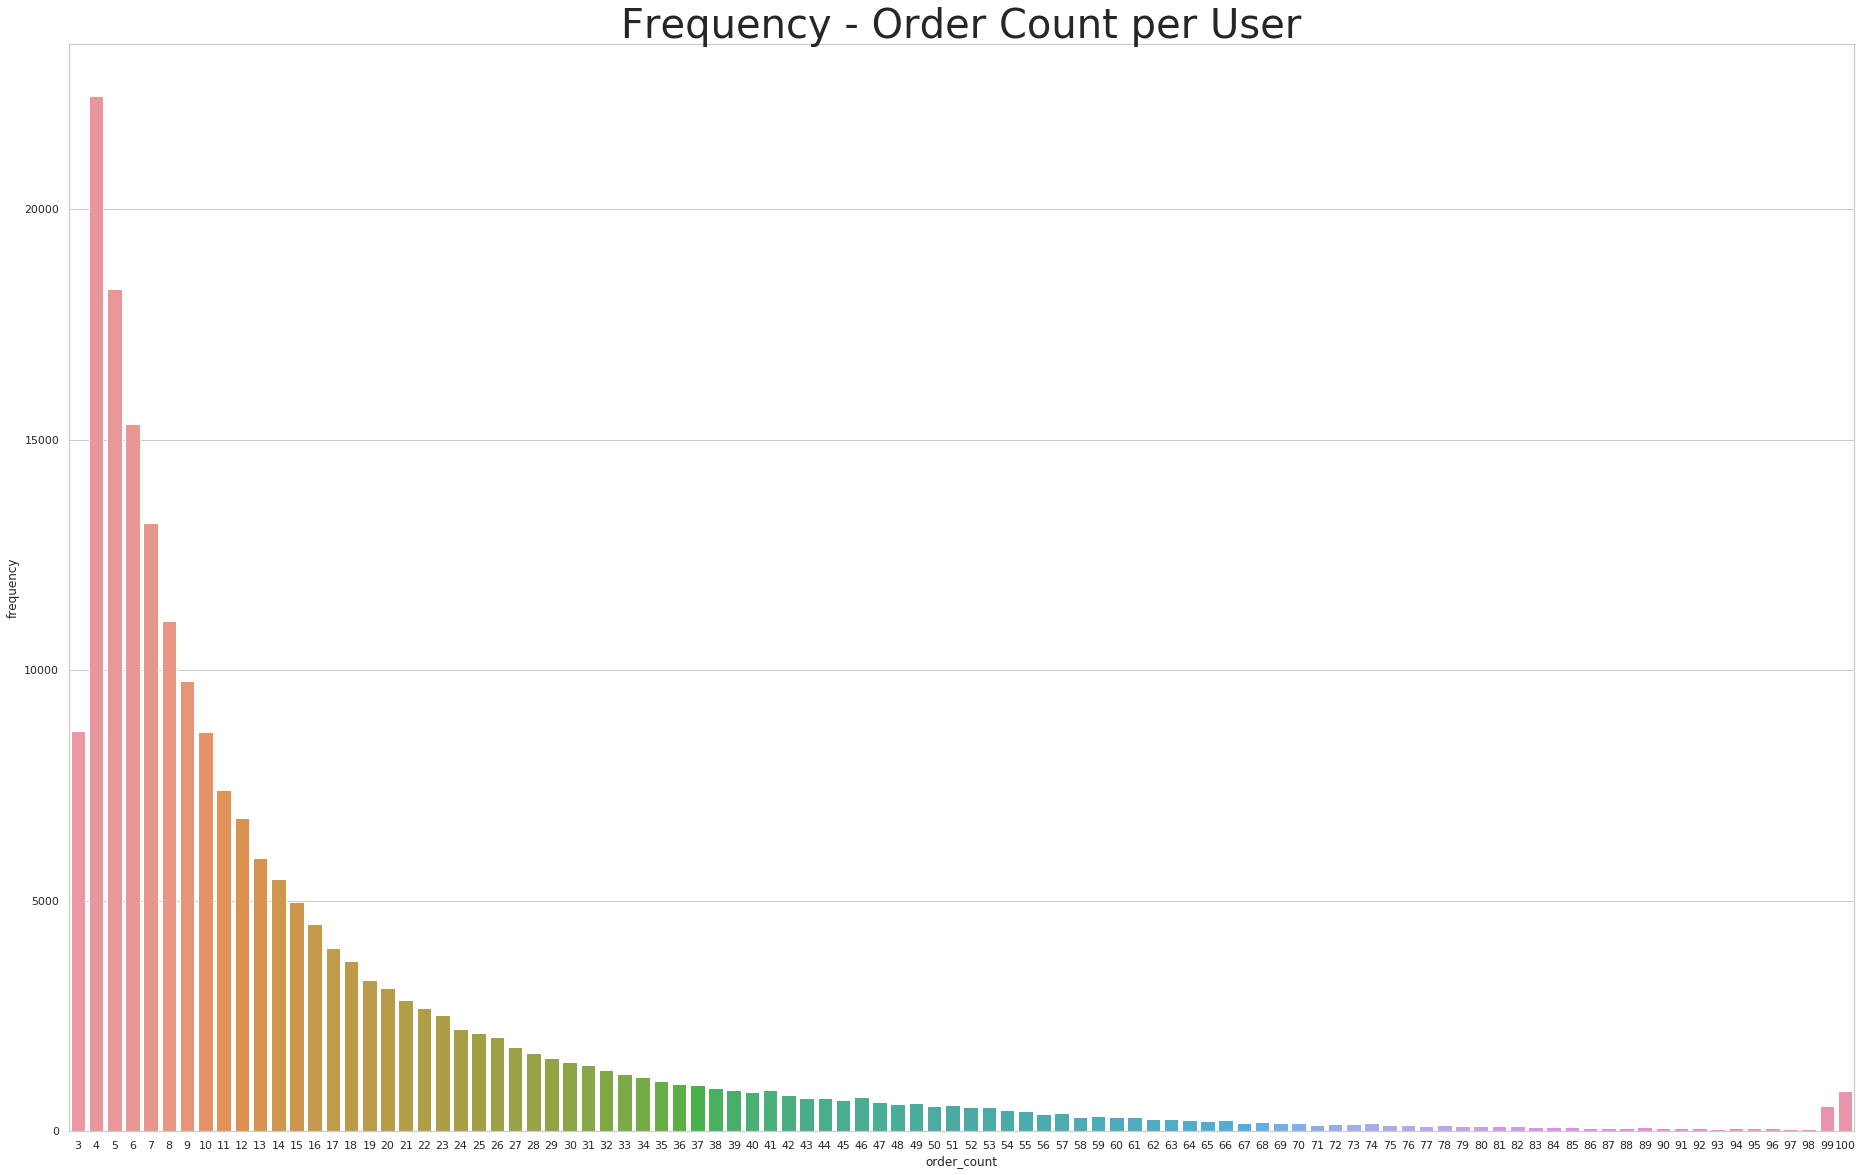

In [153]:
plt.figure(figsize=(32,20))
ax = sns.barplot(x='order_count', y='frequency', data=user_order_count)
plt.title('Frequency - Order Count per User', fontsize=40)

Min orders = 3. Max orders = 100.
At least 50% of customers have at least 10 orders (note possible limits). At least 75%, at least 15 orders

In [134]:
# Rank of popularity by product
product_count = df['product_name'].value_counts().reset_index().head(20)
product_count.columns = ['product_name', 'frequency_count']
product_count

,product_name,frequency_count
0,Banana,491291
1,Bag of Organic Bananas,394930
2,Organic Strawberries,275577
3,Organic Baby Spinach,251705
4,Organic Hass Avocado,220877
5,Organic Avocado,184224
6,Large Lemon,160792
7,Strawberries,149445
8,Limes,146660
9,Organic Whole Milk,142813


The most popular products are produce (and organic!). Instacart is a destination to buy organic produce. 

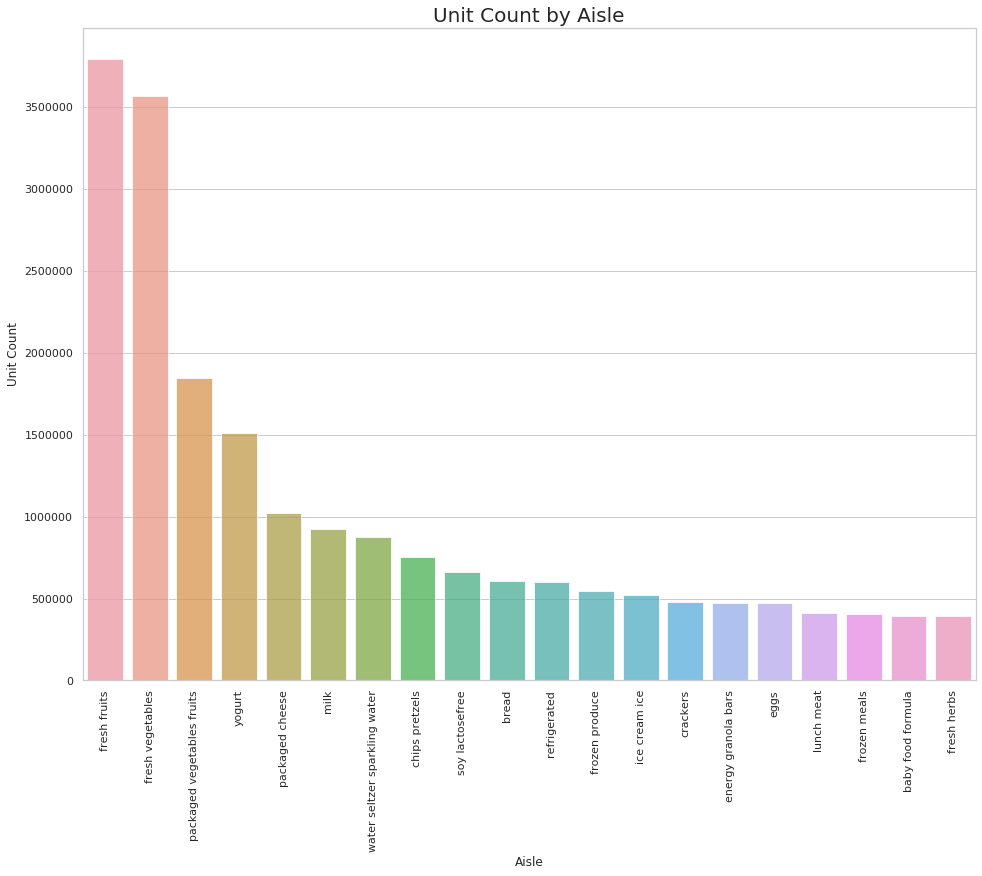

In [174]:
top_aisles = df['aisle'].value_counts().head(20)
plt.figure(figsize=(16,12))
sns.barplot(top_aisles.index, top_aisles.values, alpha=0.75)
plt.ylabel('Unit Count', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation=90)
plt.title('Unit Count by Aisle', fontsize=20)
plt.show()

As expected from the products list, the most popular aisles are fruit fruit/vegetables and it is followed by dairy. Interesting to see water in the mix (perhaps we should focus on it as water should be naturally purchased a lot). Ironic to see that soon after fresh products and water, the next aisle is junk food (chips pretzels). I wonder if these are the same customers or if customers tend to stick to "healthy" vs "not"

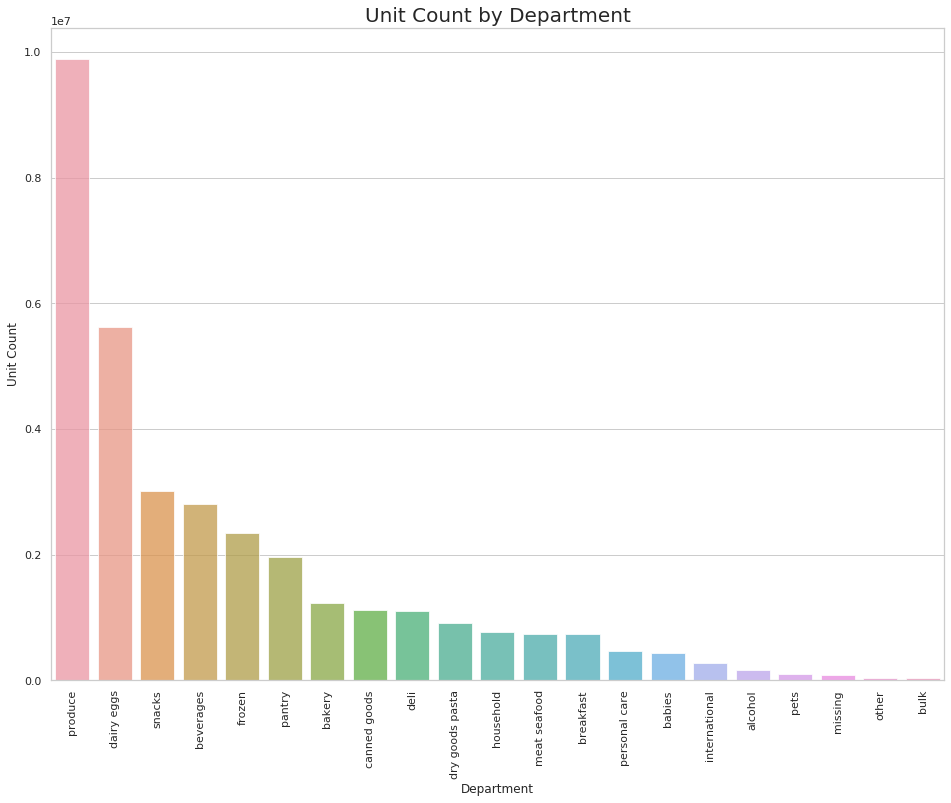

In [176]:
# review departments 

departments = df['department'].value_counts()
plt.figure(figsize=(16,12))
sns.barplot(departments.index, departments.values, alpha=0.75)
plt.ylabel('Unit Count', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.xticks(rotation=90)
plt.title('Unit Count by Department', fontsize=20)
plt.show()

Consistent with findings, produce is the most popular departments followed by dairy. 
Again, snacks and beverages show up soon after. 

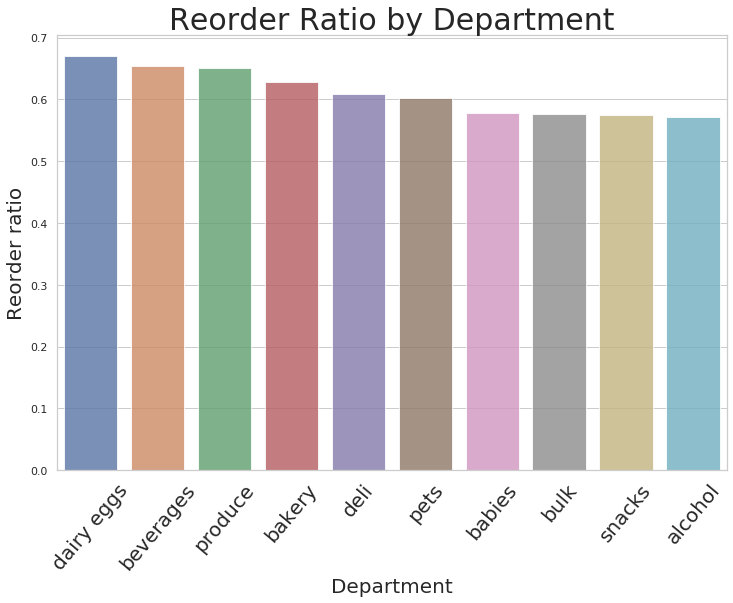

In [914]:
# Instead of looking at counts (popularity), let's look at reordered ratio. 
grouped_df = df.groupby(["department"])["reordered"].aggregate("mean").reset_index().sort_values(by='reordered',ascending=False).head(10)

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8)
plt.ylabel('Reorder ratio', fontsize=20)
plt.xlabel('Department', fontsize=20)
plt.title("Reorder Ratio by Department", fontsize=30)
plt.xticks(rotation=50, fontsize=20)
plt.show()

In [906]:
grouped_df

,department,reordered
7,dairy eggs,0.67%
3,beverages,0.65%
19,produce,0.65%
2,bakery,0.63%
8,deli,0.61%
18,pets,0.60%
1,babies,0.58%
5,bulk,0.58%
20,snacks,0.57%
0,alcohol,0.57%


In [908]:
grouped_df = df.groupby(["department"])["reordered"].aggregate("mean").reset_index().sort_values(by='reordered',ascending=False)

In [909]:
grouped_df['reordered'].mean()

0.521475367596308

Ha! Interestingly, produce which is by far the most popular IS NOT the most likely to be reordered. Actually, products most likely to be reordered are dairy and beverages. Beverages is a great market as it lends itseld to be reordered.

Also, important to note that personal care, pantry, and international are the least likely to be reordered. Some make sense like international (that you may be experimenting with) or pantry (that might be kept for longer periods of time). But..are there perhaps areas of opportunities. Shouldn't personal care products lend themselves naturally to being reordered? Shouldn't household products be naturally reordered?

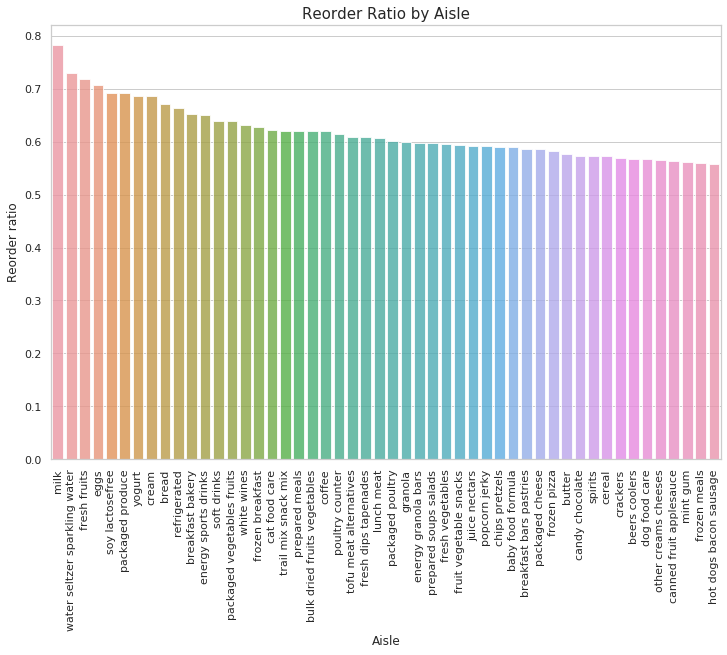

In [180]:
grouped_df = df.groupby(["aisle"])["reordered"].aggregate("mean").reset_index().sort_values(by='reordered',ascending=False).head(50)

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['aisle'].values, grouped_df['reordered'].values, alpha=0.8)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.title("Reorder Ratio by Aisle", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

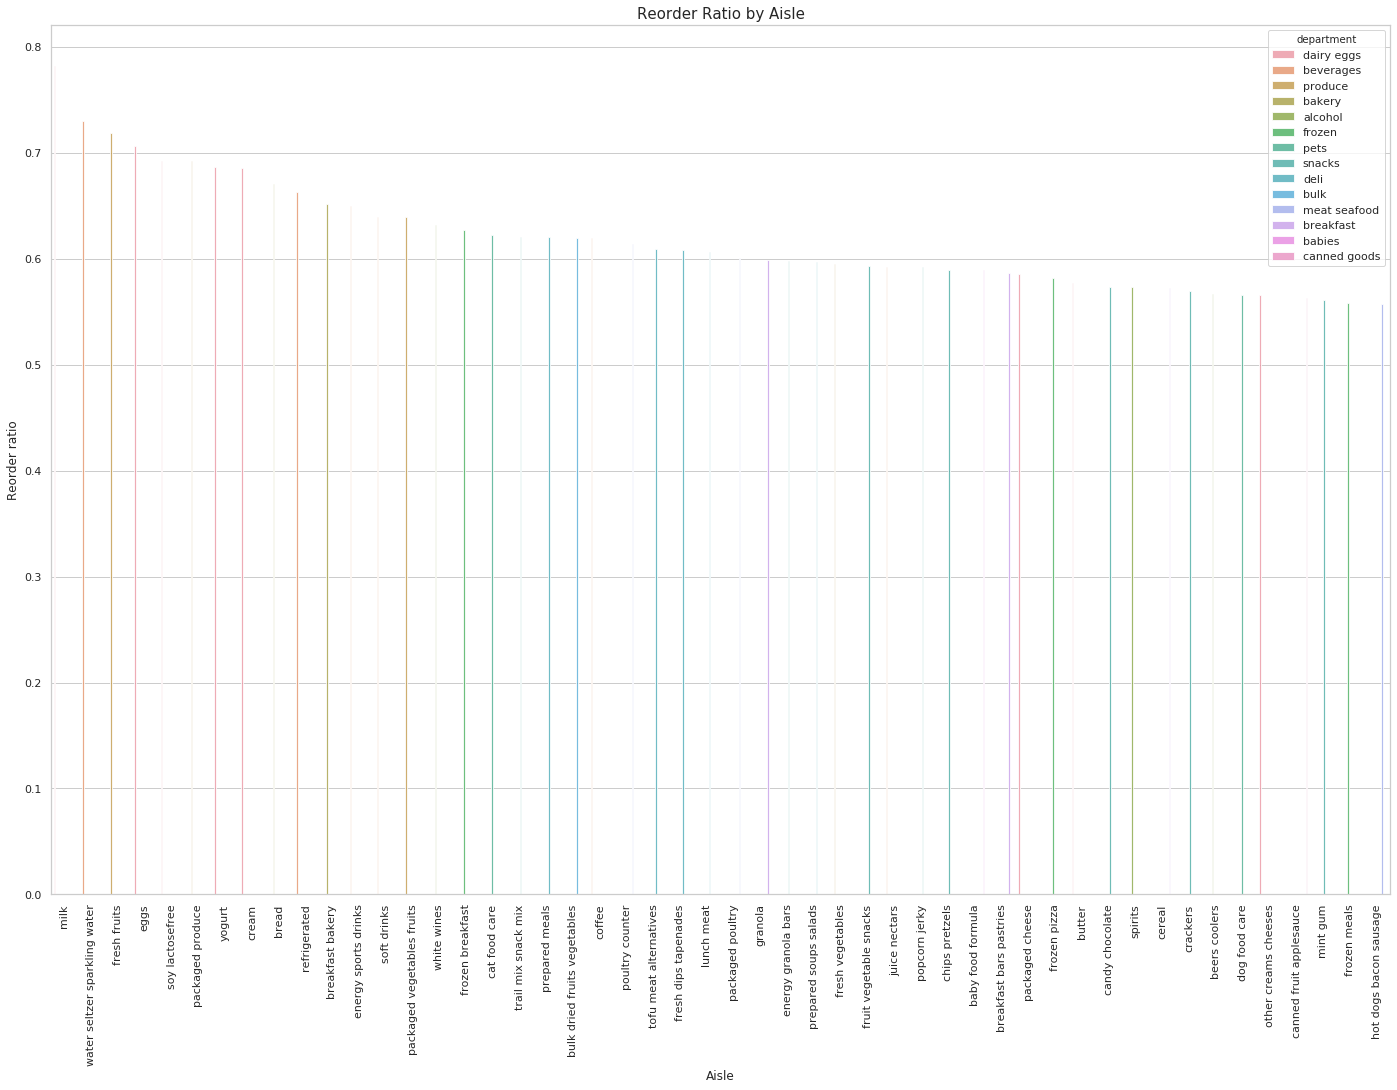

In [181]:
grouped_df = df.groupby(["department","aisle"])["reordered"].aggregate("mean").reset_index().sort_values(by='reordered',ascending=False).head(50)

plt.figure(figsize=(24,16))
sns.barplot(grouped_df['aisle'].values, grouped_df['reordered'].values, alpha=0.8, hue=grouped_df['department'])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.title("Reorder Ratio by Aisle", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Top 50 aisles belong to 20 departments. Some surprises and areas of opportunity include alcohol, pets, and bulk.

Idea - Compare timing of Instacart Alcohol launch. Same year? Or did they start with spirits and move unto others? Perhaps access patterns of users who buy alcohol

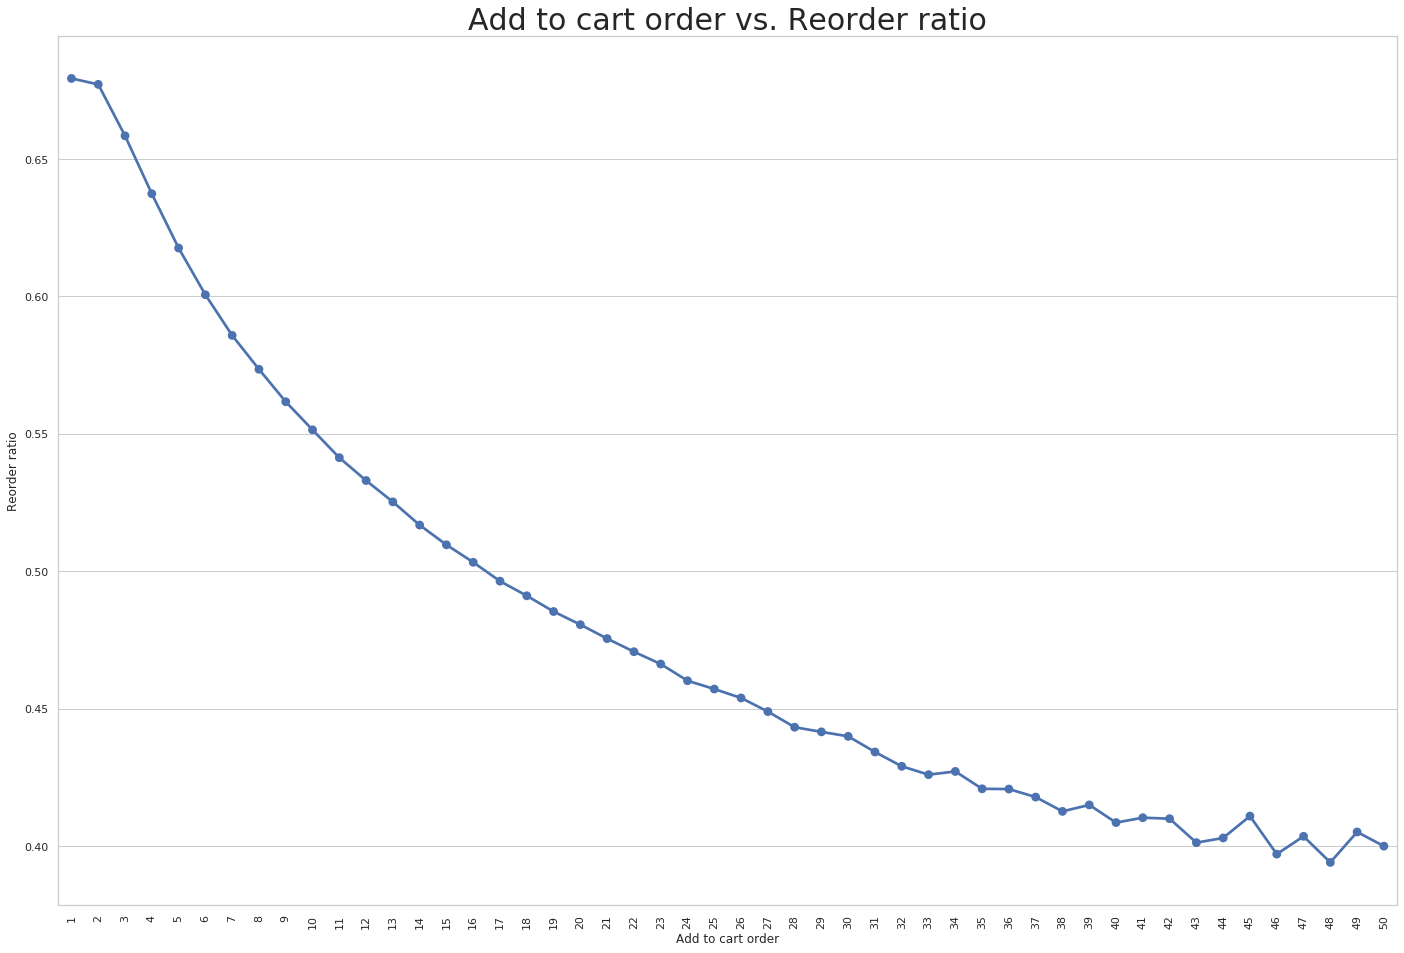

In [193]:
# reorder ratio vs. add to cart order

df["add_to_cart_order_mod"] = df["add_to_cart_order"].copy()
grouped_df = df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()
grouped_df.drop(grouped_df[grouped_df['add_to_cart_order_mod']>50].index,inplace=True)

plt.figure(figsize=(24,16))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order vs. Reorder ratio", fontsize=30)
plt.xticks(rotation='vertical')
plt.show()

There is a negative correlation between reorder ratio and add to cart order. This means that products that are reordered tend to be added to the cart first. 

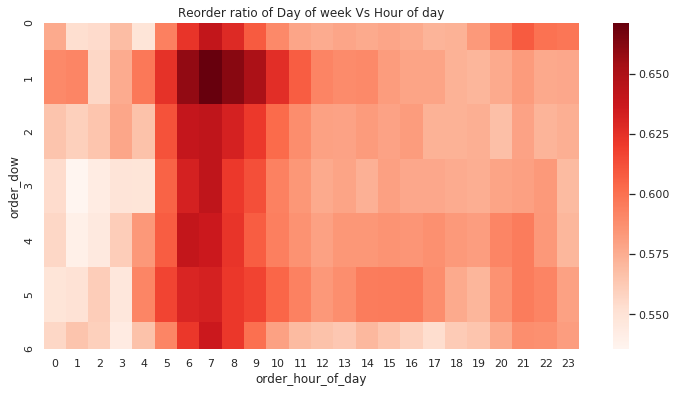

In [194]:
grouped_df = df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df, cmap="Reds")
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

Products ordered earlier in the morning are more likely to be reordered. Users are more likely to stock up on reordered items much earlier in the AM (between 6AM and 8AM) than the most popular order times which are later.

# EXPLORATORY DATA ANALYSIS - ALCOHOL

In [197]:
df.department.value_counts(normalize=True)

produce            0.292390
dairy eggs         0.166505
snacks             0.088897
beverages          0.082917
frozen             0.069099
pantry             0.057861
bakery             0.036227
canned goods       0.032965
deli               0.032394
dry goods pasta    0.026770
household          0.022906
meat seafood       0.021859
breakfast          0.021854
personal care      0.013859
babies             0.012973
international      0.008313
alcohol            0.004710
pets               0.003023
missing            0.002289
other              0.001126
bulk               0.001062
Name: department, dtype: float64

So far, alcohol accounts for less than 5% of total products sold in Instacart which is understandable because it is only available on a few cities. But, its importance cannot be denied as competition is more limited and it is highly reordered. By March 2019, Instacart announced it was available in 14 states but in 2017 that number was smaller and this percentage currently should be much higher. Throughout the years, the company has announced each new city with alcohol delivery (often after navigating tight regulations). In 2019, Instacart continues to make moves in this area including same-day alcohol delivery through partnerships with Costco and Morton Williams. 

What trends did Instacart see that advised and/or would help advise its clear strategy to expand this department? 

## Product Level

In [249]:
alcohol = df[df.department == 'alcohol']
alcohol=alcohol.copy()

In [226]:
non_alcohol = df[df.department != 'alcohol']

In [227]:
len(alcohol)+len(non_alcohol)==len(df)

True

In [230]:
alcohol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159294 entries, 412 to 33818996
Data columns (total 16 columns):
aisle_id                  159294 non-null int64
department_id             159294 non-null int64
product_id                159294 non-null int64
order_id                  159294 non-null int64
user_id                   159294 non-null int64
eval_set                  159294 non-null object
order_number              159294 non-null int64
order_dow                 159294 non-null int64
order_hour_of_day         159294 non-null int64
days_since_prior_order    146580 non-null float64
add_to_cart_order         159294 non-null int64
reordered                 159294 non-null int64
product_name              159294 non-null object
department                159294 non-null object
aisle                     159294 non-null object
add_to_cart_order_mod     159294 non-null int64
dtypes: float64(1), int64(11), object(4)
memory usage: 20.7+ MB


In [208]:
alcohol.head()

,aisle_id,department_id,product_id,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,department,aisle,add_to_cart_order_mod
412,27,5,42781,45533,169647,prior,8,4,10,7.0,9,1,Pale Ale Beer,alcohol,beers coolers,9
414,27,5,48241,45533,169647,prior,8,4,10,7.0,2,1,Sculpin IPA,alcohol,beers coolers,2
614,124,5,7261,64887,169647,prior,33,4,16,14.0,47,0,Elderflower Liqueur,alcohol,spirits,47
616,27,5,16449,64887,169647,prior,33,4,16,14.0,46,0,Original Irish Cider,alcohol,beers coolers,46
619,62,5,33001,64887,169647,prior,33,4,16,14.0,45,0,White Wine,alcohol,white wines,45


In [209]:
alcohol.describe()

,aisle_id,department_id,product_id,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,add_to_cart_order_mod
count,159294.000000,159294.0,159294.000000,1.592940e+05,159294.000000,159294.000000,159294.000000,159294.000000,146580.000000,159294.000000,159294.000000,159294.000000
mean,59.714603,5.0,26175.838964,1.711514e+06,103902.142742,15.216260,3.165449,13.599301,10.580966,5.435961,0.571221,5.435961
std,41.573367,0.0,15375.648020,9.875311e+05,59069.704702,16.857324,1.918716,3.684343,9.183064,5.799931,0.494903,5.799931
min,27.000000,5.0,52.000000,1.300000e+01,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,27.000000,5.0,12013.000000,8.501830e+05,53020.000000,4.000000,2.000000,11.000000,4.000000,2.000000,0.000000,2.000000
50%,28.000000,5.0,28578.000000,1.716394e+06,104433.000000,9.000000,3.000000,14.000000,7.000000,3.000000,1.000000,3.000000
75%,124.000000,5.0,39685.000000,2.567239e+06,155820.000000,20.000000,5.000000,16.000000,15.000000,7.000000,1.000000,7.000000
max,134.000000,5.0,49684.000000,3.421040e+06,206182.000000,100.000000,6.000000,23.000000,30.000000,90.000000,1.000000,90.000000


In [228]:
non_alcohol.head()

,aisle_id,department_id,product_id,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,department,aisle,add_to_cart_order_mod,alcohol_bol
0,89,13,37371,114,91891,prior,1,0,11,NaN,3,0,Homestyle Ranch,pantry,salad dressing toppings,3,0.0
1,91,16,9036,488,127848,prior,22,1,19,4.0,2,1,Unsweetened Vanilla Cashew Milk,dairy eggs,soy lactosefree,2,0.0
2,91,16,24838,488,127848,prior,22,1,19,4.0,6,1,Unsweetened Almondmilk,dairy eggs,soy lactosefree,6,0.0
3,116,1,43647,683,152537,prior,3,0,15,30.0,6,0,Organic Asparagus Spears,frozen,frozen produce,6,0.0
4,67,20,21986,733,62760,prior,3,5,21,13.0,1,1,Artichoke Parmesan Dip,deli,fresh dips tapenades,1,0.0


In [229]:
non_alcohol.describe()

,aisle_id,department_id,product_id,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,add_to_cart_order_mod,alcohol_bol
count,3.365981e+07,3.365981e+07,3.365981e+07,3.365981e+07,3.365981e+07,3.365981e+07,3.365981e+07,3.365981e+07,3.159446e+07,3.365981e+07,3.365981e+07,3.365981e+07,33659812.0
mean,7.127242e+01,9.941821e+00,2.557267e+04,1.710562e+06,1.029399e+05,1.714908e+01,2.735259e+00,1.343043e+01,1.136779e+01,8.381612e+00,5.901509e-01,8.381612e+00,0.0
std,3.817406e+01,6.287360e+00,1.409131e+04,9.874002e+05,5.946917e+04,1.750076e+01,2.093879e+00,4.248616e+00,8.939200e+00,7.142422e+00,4.918057e-01,7.142422e+00,0.0
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.0
25%,3.100000e+01,4.000000e+00,1.353175e+04,8.554300e+05,5.143000e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00,3.000000e+00,0.000000e+00,3.000000e+00,0.0
50%,8.300000e+01,9.000000e+00,2.523000e+04,1.710637e+06,1.026170e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00,6.000000e+00,1.000000e+00,6.000000e+00,0.0
75%,1.070000e+02,1.600000e+01,3.790400e+04,2.565573e+06,1.544090e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01,1.200000e+01,1.000000e+00,1.200000e+01,0.0
max,1.330000e+02,2.100000e+01,4.968800e+04,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,1.450000e+02,1.000000e+00,1.450000e+02,0.0


In [211]:
alcohol.aisle.value_counts(normalize=True)

beers coolers                 0.316999
red wines                     0.228659
white wines                   0.198664
spirits                       0.182486
specialty wines champagnes    0.073192
Name: aisle, dtype: float64

In [212]:
alcohol_breakdown = alcohol.aisle.value_counts(sort=True)

In [225]:
alcohol_breakdown

beers coolers                 50496
red wines                     36424
white wines                   31646
spirits                       29069
specialty wines champagnes    11659
Name: aisle, dtype: int64

In [213]:
type(alcohol_breakdown)

pandas.core.series.Series

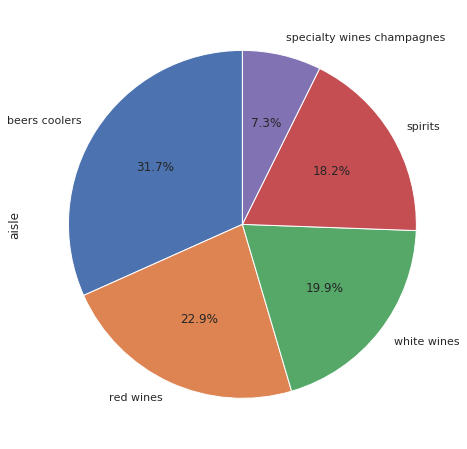

In [214]:
alcohol_breakdown.plot.pie(figsize=(8,8), autopct='%1.1f%%', startangle=90)

A closer look at the alcohol products sold showcases that wines are purchased significantly more than beer/coolers and spirits. Availability of spirits is more limited but the difference between wines and beers (which are more likely to be purchased in bulk) is interesting.

As availability / regulation will typically be grouped by wine, beer, and spirits. We will look at those 3 groups separately

In [215]:
# for comparison
df.loc[df['department'] == 'alcohol', 'alcohol_bol'] = 1
df.loc[df['department'] != 'alcohol', 'alcohol_bol'] = 0 

In [247]:
df.alcohol_bol.value_counts(sort=True)

0.0    33659812
1.0      159294
Name: alcohol_bol, dtype: int64

In [248]:
df.alcohol_bol.value_counts(normalize=True)

0.0    0.99529
1.0    0.00471
Name: alcohol_bol, dtype: float64

Alcohol accounts for less than 1% of products sold in IC

In [250]:
# for overall view of 3 segments.
alcohol.loc[alcohol['aisle'] == 'white wines', 'alcohol_type'] = 'wine'
alcohol.loc[alcohol['aisle'] == 'red wines', 'alcohol_type'] = 'wine'
alcohol.loc[alcohol['aisle'] == 'specialty wines champagnes', 'alcohol_type'] = 'wine'
alcohol.loc[alcohol['aisle'] == 'beers coolers', 'alcohol_type'] = 'beer_cooler'
alcohol.loc[alcohol['aisle'] == 'spirits', 'alcohol_type'] = 'spirits'

In [946]:
alcohol.alcohol_type.value_counts(sort=True)

wine           79729
beer_cooler    50496
spirits        29069
Name: alcohol_type, dtype: int64

In [254]:
alcohol.alcohol_type.value_counts(sort=True, normalize=True)

wine           0.500515
beer_cooler    0.316999
spirits        0.182486
Name: alcohol_type, dtype: float64

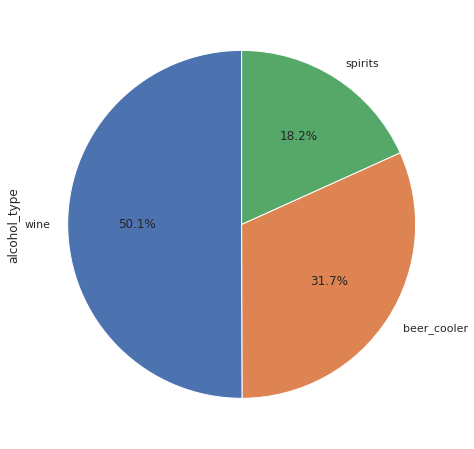

In [916]:
alcohol.alcohol_type.value_counts().plot.pie(figsize=(8,8), autopct='%1.1f%%', startangle=90)

Of alcohol drinks, wine is the most popularly sold. Wine accounts for more than 50% of the alcohol sold with beers at about 32% and  spirits at 18%. 

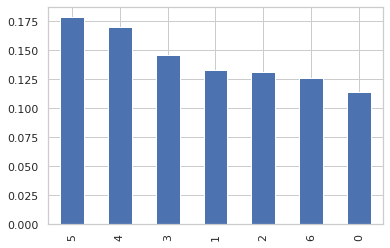

In [271]:
# number of alcohol products ordered by day of the week
alcohol.order_dow.value_counts(sort=True, normalize=True).plot.bar()

In [273]:
alcohol.order_dow.value_counts(sort=True, normalize=True)

5   0.18%
4   0.17%
3   0.15%
1   0.13%
2   0.13%
6   0.13%
0   0.11%
Name: order_dow, dtype: float64

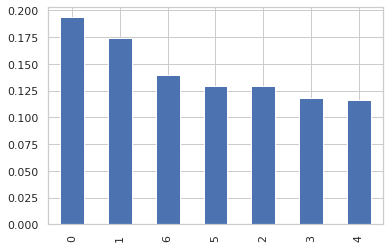

In [272]:
non_alcohol.order_dow.value_counts(sort=True, normalize=True).plot.bar()

alcohol vs. non-alcohol products: While non-alcohol products, are most popularly ordered on weekends. Unlike non-alcohol products, alcohol tends to be purchased on weekdays: particularly later in the week with the Peak on Friday (18%) followed by Thursday (17%) and Wednesday (15%). 

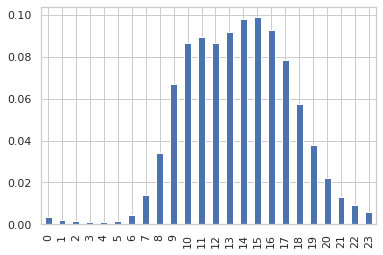

In [274]:
# number of alcohol products ordered by HOD
alcohol.order_hour_of_day.value_counts(sort=False, normalize=True).plot.bar()

In [275]:
alcohol.order_hour_of_day.value_counts(sort=True, normalize=True)

15   0.10%
14   0.10%
16   0.09%
13   0.09%
11   0.09%
10   0.09%
12   0.09%
17   0.08%
9    0.07%
18   0.06%
19   0.04%
8    0.03%
20   0.02%
7    0.01%
21   0.01%
22   0.01%
23   0.01%
6    0.00%
0    0.00%
1    0.00%
5    0.00%
2    0.00%
4    0.00%
3    0.00%
Name: order_hour_of_day, dtype: float64

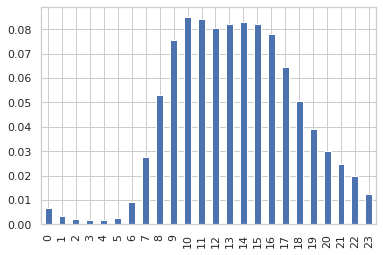

In [276]:
non_alcohol.order_hour_of_day.value_counts(sort=False, normalize=True).plot.bar()

In [277]:
non_alcohol.order_hour_of_day.value_counts(sort=True, normalize=True)

10   0.09%
11   0.08%
14   0.08%
15   0.08%
13   0.08%
12   0.08%
16   0.08%
9    0.08%
17   0.06%
8    0.05%
18   0.05%
19   0.04%
20   0.03%
7    0.03%
21   0.02%
22   0.02%
23   0.01%
6    0.01%
0    0.01%
1    0.00%
5    0.00%
2    0.00%
4    0.00%
3    0.00%
Name: order_hour_of_day, dtype: float64

alcohol vs. non-alcohol products: While non-alcohol products, are most popularly ordered in the morning (peak 10AM-12PM). Unlike non-alcohol products, alcohol tends to be purchased later in the day (peak 1PM-4PM)

Note: Better visualization will split hours into segments

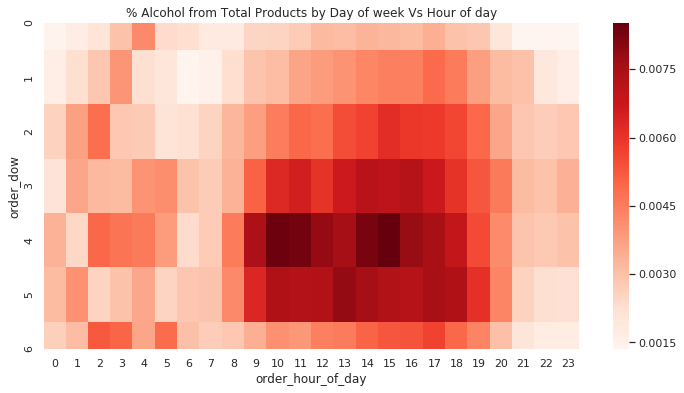

In [1241]:
grouped_df = df.groupby(["order_dow", "order_hour_of_day"])["alcohol_bol"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'alcohol_bol')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df, cmap="Reds")
plt.title("% Alcohol from Total Products by Day of week Vs Hour of day")
plt.show()

In [1242]:
grouped_df

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
1,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.01%,0.01%,0.01%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%
3,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%,...,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%
4,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%,...,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%
5,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.01%,...,0.01%,0.01%,0.01%,0.01%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%
6,0.00%,0.00%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.01%,0.01%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


Regarding hour/day combinations. The biggest peak of alcohol products purchased is Wednesday mid-day!!! Followed by Thursday. Hump Day?

In [288]:
alcohol.days_since_prior_order.value_counts(sort=True, normalize=True)

30.00%   0.10%
7.00%    0.09%
2.00%    0.07%
3.00%    0.07%
6.00%    0.07%
4.00%    0.07%
1.00%    0.06%
5.00%    0.06%
8.00%    0.05%
9.00%    0.03%
0.00%    0.03%
14.00%   0.03%
10.00%   0.03%
13.00%   0.03%
12.00%   0.02%
11.00%   0.02%
15.00%   0.02%
21.00%   0.02%
16.00%   0.01%
20.00%   0.01%
17.00%   0.01%
18.00%   0.01%
19.00%   0.01%
22.00%   0.01%
28.00%   0.01%
23.00%   0.01%
27.00%   0.01%
26.00%   0.01%
25.00%   0.01%
24.00%   0.01%
29.00%   0.01%
Name: days_since_prior_order, dtype: float64

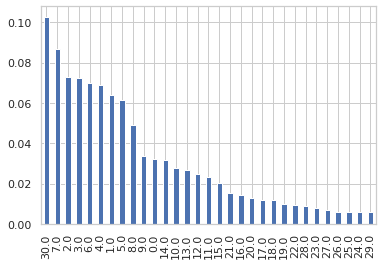

In [292]:
alcohol.days_since_prior_order.value_counts(sort=True, normalize=True).plot.bar()

In [293]:
non_alcohol.days_since_prior_order.value_counts(sort=True, normalize=True)

7.00%    0.11%
30.00%   0.11%
6.00%    0.08%
5.00%    0.07%
4.00%    0.07%
8.00%    0.06%
3.00%    0.06%
2.00%    0.05%
9.00%    0.04%
14.00%   0.03%
10.00%   0.03%
1.00%    0.03%
13.00%   0.03%
11.00%   0.03%
12.00%   0.03%
15.00%   0.02%
16.00%   0.02%
21.00%   0.01%
0.00%    0.01%
20.00%   0.01%
17.00%   0.01%
18.00%   0.01%
19.00%   0.01%
22.00%   0.01%
28.00%   0.01%
23.00%   0.01%
27.00%   0.01%
24.00%   0.01%
25.00%   0.01%
29.00%   0.01%
26.00%   0.01%
Name: days_since_prior_order, dtype: float64

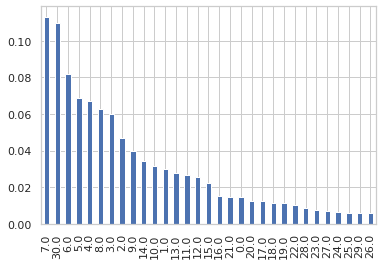

In [294]:
non_alcohol.days_since_prior_order.value_counts(sort=True, normalize=True).plot.bar()

In general, orders tend to be ordered qeekly. no finding (alcohol vs not) = alcohol and non-alcohol products are equally likely to be ordered weekly (7 days since last order)

In [330]:
grouped_df = df.groupby('alcohol_bol').agg({'order_id': np.size, 'reordered': np.sum})
grouped_df['reordered_ratio'] = grouped_df['reordered']/grouped_df['order_id']
grouped_df.rename(columns={"order_id": "product_count", "reordered": "reordered_count"})

,product_count,reordered_count,reordered_ratio
alcohol_bol,,,
0.00%,33659812,19864368,0.59%
1.00%,159294,90992,0.57%


No finding - reorder ratio of alcohol vs non-alcohol products is similar (57% vs. 59%)

In [334]:
grouped_df = alcohol.groupby('alcohol_type').agg({'aisle': np.size, 'reordered': np.sum})
grouped_df['reordered_ratio'] = grouped_df['reordered']/grouped_df['aisle']
grouped_df.rename(columns={"aisle": "product_count", "reordered": "reordered_count"})

,product_count,reordered_count,reordered_ratio
alcohol_type,,,
beer_cooler,50496,28627,0.57%
spirits,29069,16652,0.57%
wine,79729,45713,0.57%


No insight: each alcohol type has the same likely change to be reordered

In [335]:
grouped_df = alcohol.groupby('aisle').agg({'aisle': np.size, 'reordered': np.sum})
grouped_df['reordered_ratio'] = grouped_df['reordered']/grouped_df['aisle']
grouped_df.rename(columns={"aisle": "product_count", "reordered": "reordered_count"})

,product_count,reordered_count,reordered_ratio
aisle,,,
beers coolers,50496,28627,0.57%
red wines,36424,20034,0.55%
specialty wines champagnes,11659,5681,0.49%
spirits,29069,16652,0.57%
white wines,31646,19998,0.63%


Broken down by aisle, there are some insights on the wine. White wine is much more likely to be reordered than red and champagne subsequently. As a matter of fact, specialty wines champagnes lag on reorder ratio significantly within wine category. Perhaps they are ordered just on special ocassions?

Let's look at orders

In [395]:
order_aisle_crosstab = pd.crosstab(df.order_id, df.aisle, margins=True, margins_name="Total_Products")

In [237]:
order_aisle_crosstab.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,Total
order_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,8
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,8
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,13
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,26


In [238]:
order_aisle_crosstab.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3346084 entries, 1 to Total
Columns: 135 entries, air fresheners candles to Total
dtypes: int64(135)
memory usage: 3.4+ GB


In [371]:
order_department_crosstab = pd.crosstab(df.order_id, df.department, margins=True, margins_name="Total_Products") 

In [382]:
order_department_crosstab.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,missing,other,pantry,personal care,pets,produce,snacks,Total_Products,alcohol_proportion,alcohol_vs_other
order_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,1,3,0,0,...,0,0,0,0,0,4,0,8,0.00%,no alcohol
2,0,0,0,0,0,0,0,1,0,0,...,0,0,5,0,0,3,0,9,0.00%,no alcohol
3,0,0,1,0,0,0,0,3,0,0,...,0,0,0,0,0,3,0,8,0.00%,no alcohol
4,0,0,1,3,4,0,0,0,0,0,...,0,0,0,1,0,0,4,13,0.00%,no alcohol
5,0,0,0,1,0,0,0,3,1,2,...,0,0,2,1,0,7,4,26,0.00%,no alcohol


In [372]:
order_department_crosstab['alcohol_proportion'] = order_department_crosstab['alcohol']/order_department_crosstab['Total_Products']

In [373]:
order_department_crosstab.loc[order_department_crosstab['alcohol_proportion'] == 1, 'alcohol_vs_other'] = 'alcohol_only'
order_department_crosstab.loc[order_department_crosstab['alcohol_proportion'] == 0, 'alcohol_vs_other'] = 'no alcohol'
order_department_crosstab['alcohol_vs_other'] = order_department_crosstab.alcohol_vs_other.fillna('alcohol & more')

In [374]:
order_department_crosstab.alcohol_vs_other.value_counts(sort=True)

no alcohol        3258289
alcohol & more      77790
alcohol_only        10005
Name: alcohol_vs_other, dtype: int64

In [383]:
order_department_crosstab.alcohol_vs_other.value_counts(normalize=True)

no alcohol       0.97%
alcohol & more   0.02%
alcohol_only     0.00%
Name: alcohol_vs_other, dtype: float64

In [376]:
order_department_crosstab['alcohol_proportion'].max()

1.0

In [378]:
order_department_crosstab['alcohol_proportion'].min()

0.0

Surprisingly, the likelihood that an order with alcohol included non-alcohol items is more than double the chance that it doesn't. For every 1 order of alcohol only: 7 include both!. There is opportunity here to explore what is being purchased with alcohol. 

In [384]:
77790/10005

7.775112443778111

Let's look at users

In [388]:
user_department_crosstab = pd.crosstab(df.user_id, df.department, margins=True, margins_name="Total_Products") 

In [585]:
user_department_crosstab

In [390]:
user_department_crosstab['alcohol_proportion'] = user_department_crosstab['alcohol']/user_department_crosstab['Total_Products']

In [391]:
user_department_crosstab.loc[user_department_crosstab['alcohol_proportion'] == 1, 'alcohol_vs_other'] = 'alcohol_only'
user_department_crosstab.loc[user_department_crosstab['alcohol_proportion'] == 0, 'alcohol_vs_other'] = 'no alcohol'
user_department_crosstab['alcohol_vs_other'] =user_department_crosstab.alcohol_vs_other.fillna('alcohol & more')

In [392]:
user_department_crosstab.alcohol_vs_other.value_counts(sort=True)

no alcohol        190105
alcohol & more     16060
alcohol_only          45
Name: alcohol_vs_other, dtype: int64

In [393]:
user_department_crosstab.alcohol_vs_other.value_counts(normalize=True)

no alcohol       0.92%
alcohol & more   0.08%
alcohol_only     0.00%
Name: alcohol_vs_other, dtype: float64

Big Insight: Demand > Supply. Expansion is informed and going the right direction

Despite alcohol being less than 5% total products. More than 8% of users have purchased alcohol. A telling sign that interest (demand) is outpacing supply. Instacart is making strides to address this but needs data to conduct informed negotiations with retailers (and possibly gov officials) 

In [608]:
# orders with alcohol vs. orders without.
# avg reordered ratio
# avg days since last order
# avg product count
# heat map / times
# in orders with alcohol,  was alcohol item #1 bol?

In [609]:
# users that have ordered alcohol vs not.
# avg number of orders

In [659]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 17 columns):
aisle_id                  int64
department_id             int64
product_id                int64
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
add_to_cart_order         int64
reordered                 int64
product_name              object
department                object
aisle                     object
add_to_cart_order_mod     int64
alcohol_bol               float64
dtypes: float64(2), int64(11), object(4)
memory usage: 4.3+ GB


## Alcohol vs. Non-alcohol

### Product

In [887]:
products_df = pd.read_csv('raw/products-raw.csv',na_values=['NULL'])

In [869]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [875]:
departments_df = pd.read_csv('raw/departments.csv',na_values=['NULL'])

In [871]:
departments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
department_id    21 non-null int64
department       21 non-null object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [888]:
products_df = pd.merge(products_df, departments_df, on='department_id', how='left')

In [889]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49688 entries, 0 to 49687
Data columns (total 5 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
department       49688 non-null object
dtypes: int64(3), object(2)
memory usage: 2.3+ MB


In [894]:
len(products_df)

49688

In [896]:
products_df['department'].value_counts()

personal care      6563
snacks             6264
pantry             5371
beverages          4365
frozen             4007
dairy eggs         3449
household          3085
canned goods       2092
dry goods pasta    1858
produce            1684
bakery             1516
deli               1322
missing            1258
international      1139
breakfast          1115
babies             1081
alcohol            1054
pets                972
meat seafood        907
other               548
bulk                 38
Name: department, dtype: int64

In [898]:
products_df['department'].value_counts(normalize=True)

personal care     0.13%
snacks            0.13%
pantry            0.11%
beverages         0.09%
frozen            0.08%
dairy eggs        0.07%
household         0.06%
canned goods      0.04%
dry goods pasta   0.04%
produce           0.03%
bakery            0.03%
deli              0.03%
missing           0.03%
international     0.02%
breakfast         0.02%
babies            0.02%
alcohol           0.02%
pets              0.02%
meat seafood      0.02%
other             0.01%
bulk              0.00%
Name: department, dtype: float64

In [834]:
alcohol_sold_product_ids = df.loc[df['department'] == 'alcohol', 'product_id'].drop_duplicates().tolist()
alcohol_sold_product_ids

[42781,
 48241,
 7261,
 16449,
 33001,
 49544,
 11900,
 15773,
 15847,
 6442,
 43892,
 46715,
 40844,
 20704,
 7813,
 42148,
 33684,
 43298,
 7064,
 35357,
 522,
 24232,
 36601,
 13911,
 38347,
 28247,
 23460,
 1401,
 19801,
 18804,
 36885,
 49349,
 28238,
 39547,
 11260,
 30706,
 36716,
 34568,
 44150,
 16326,
 35330,
 26205,
 9235,
 34681,
 32838,
 19640,
 32551,
 24530,
 15511,
 2049,
 40111,
 49684,
 49292,
 36269,
 28509,
 12825,
 25381,
 36889,
 41152,
 25080,
 39957,
 3149,
 17271,
 27221,
 22019,
 26245,
 3877,
 17392,
 41681,
 43558,
 8660,
 32930,
 37039,
 31673,
 10951,
 23708,
 48282,
 11293,
 49523,
 18458,
 7448,
 3745,
 45294,
 2251,
 3003,
 40803,
 28612,
 24851,
 20456,
 9425,
 25749,
 36879,
 567,
 15329,
 11969,
 34367,
 21466,
 1857,
 12724,
 9287,
 49167,
 24757,
 45131,
 29969,
 10470,
 45811,
 10171,
 18060,
 39641,
 18602,
 20224,
 38165,
 1345,
 35987,
 3570,
 4218,
 4027,
 10486,
 11164,
 35811,
 18197,
 36455,
 17816,
 11318,
 28992,
 17211,
 25161,
 26067,
 

In [835]:
len(alcohol_sold_product_ids)

1054

In [836]:
len(alcohol_sold_product_ids) / len(products_df)

0.0212123651585896

Alcohol has 2% of the product inventory

In [674]:
# product alcohol vs. not
# reorder ratio
grouped_df = DataFrame(df.groupby(['product_id', 'alcohol_bol'])["reordered"].aggregate("mean"))
grouped_df = grouped_df.groupby(['alcohol_bol'])["reordered"].aggregate("mean")
grouped_df.head()

alcohol_bol
0.00%   0.37%
1.00%   0.40%
Name: reordered, dtype: float64

In [682]:
# reorder ratio of all product 
grouped_df = DataFrame(df.groupby(['product_id'])['reordered'].aggregate("mean"))
grouped_df['reordered'].mean()

0.36844362689682286

Alcohol products have a higher reorder ratio than non-alcohol products (40% vs. 37%)

In [684]:
# add_to_cart_order_mod
grouped_df = DataFrame(df.groupby(['product_id', 'alcohol_bol'])["add_to_cart_order_mod"].aggregate("mean"))
grouped_df = grouped_df.groupby(['alcohol_bol'])["add_to_cart_order_mod"].aggregate("mean")
grouped_df.head()

alcohol_bol
0.00%   9.18%
1.00%   6.41%
Name: add_to_cart_order_mod, dtype: float64

Alcohol products are added earlier to cart than non-alcohol products

In [942]:
grouped_df = DataFrame(df.groupby(['product_id', 'department'])["add_to_cart_order_mod"].aggregate("mean"))
grouped_df = DataFrame(grouped_df.groupby(['department'])["add_to_cart_order_mod"].aggregate("mean"))
grouped_df.sort_values(by='add_to_cart_order_mod', ascending=True)

,add_to_cart_order_mod
department,
alcohol,6.41%
beverages,8.19%
pets,8.21%
other,8.22%
dairy eggs,8.50%
bakery,8.52%
personal care,8.67%
household,8.82%
meat seafood,8.83%


In [918]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, alcohol to snacks
Data columns (total 1 columns):
add_to_cart_order_mod    21 non-null float64
dtypes: float64(1)
memory usage: 336.0+ bytes


In [943]:
grouped_df = pd.DataFrame(grouped_df).reset_index()
grouped_df = grouped_df.sort_values(by='add_to_cart_order_mod', ascending=True).head(10)

In [930]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 4 columns):
level_0                  10 non-null int64
index                    10 non-null int64
department               10 non-null object
add_to_cart_order_mod    10 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 400.0+ bytes


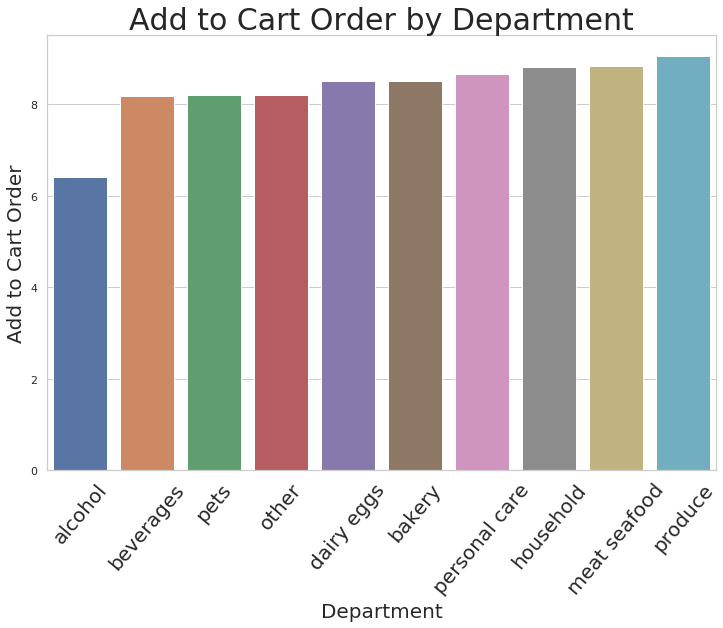

In [945]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x="department", y="add_to_cart_order_mod", data=grouped_df)
plt.ylabel('Add to Cart Order', fontsize=20)
plt.xlabel('Department', fontsize=20)
plt.title("Add to Cart Order by Department", fontsize=30)
plt.xticks(rotation=50, fontsize=20)
plt.show()

Alcohol has the LOWEST average add to cart order mod. So when a user wants to add alcohol, it is always one of the first items purchased

### Order

In [697]:
#alcohol_orders = df['order_id'].tolist()
alcohol_order_ids = df.loc[df['department'] == 'alcohol', 'order_id'].drop_duplicates().tolist()
alcohol_order_ids

[45533,
 64887,
 105048,
 109886,
 123433,
 138444,
 243874,
 249867,
 285047,
 349528,
 368854,
 427520,
 450901,
 480700,
 495881,
 527158,
 560467,
 580574,
 604000,
 611843,
 631521,
 632145,
 648447,
 774932,
 781231,
 821033,
 823961,
 825491,
 826300,
 878910,
 919469,
 998916,
 1026764,
 1027964,
 1043581,
 1094451,
 1097722,
 1132486,
 1136002,
 1170281,
 1177380,
 1208516,
 1222096,
 1337880,
 1386582,
 1420267,
 1450834,
 1459433,
 1490071,
 1494135,
 1512710,
 1577093,
 1741728,
 1824743,
 1863175,
 1923771,
 1924688,
 1982679,
 2013812,
 2019925,
 2043408,
 2043732,
 2080514,
 2113375,
 2114389,
 2119020,
 2140342,
 2141297,
 2161327,
 2173233,
 2173490,
 2209413,
 2228936,
 2234931,
 2339144,
 2339712,
 2461734,
 2476985,
 2537335,
 2545075,
 2560524,
 2562079,
 2590503,
 2643027,
 2647816,
 2648586,
 2686853,
 2712356,
 2741062,
 2744419,
 2779589,
 2780034,
 2783171,
 2798519,
 2852546,
 2852869,
 2901140,
 2905382,
 2921272,
 3011457,
 3018681,
 3058328,
 3070837,
 307

In [714]:
type(alcohol_order_ids)

list

In [699]:
len(alcohol_order_ids)

87794

In [720]:
non_alcohol_order_ids = df.loc[df['department'] != 'alcohol', 'order_id'].drop_duplicates().tolist()
non_alcohol_order_ids

[114,
 488,
 683,
 733,
 1228,
 1378,
 1644,
 2038,
 2125,
 2229,
 3205,
 3623,
 3904,
 4020,
 4177,
 4232,
 4297,
 4713,
 4780,
 4892,
 4988,
 5328,
 5489,
 5601,
 6093,
 6129,
 6455,
 6601,
 6792,
 6844,
 6939,
 7279,
 7291,
 7822,
 7867,
 8160,
 8280,
 8415,
 8435,
 8465,
 8662,
 8844,
 8930,
 9002,
 9110,
 9118,
 9287,
 9449,
 9876,
 9945,
 10010,
 10228,
 10362,
 10434,
 10475,
 10480,
 10548,
 10773,
 11378,
 11406,
 11455,
 11515,
 11734,
 11934,
 12363,
 12423,
 12987,
 13637,
 13669,
 13707,
 13825,
 14123,
 14606,
 14655,
 14700,
 14922,
 14966,
 15147,
 15470,
 15561,
 15564,
 15691,
 15728,
 15847,
 16021,
 16118,
 16560,
 16561,
 17077,
 17247,
 17274,
 17559,
 17629,
 17789,
 18045,
 18208,
 18281,
 19318,
 19421,
 19600,
 20108,
 20192,
 20275,
 20427,
 20495,
 21060,
 21070,
 21959,
 22418,
 22747,
 22833,
 23103,
 23191,
 23260,
 23401,
 23426,
 23729,
 24194,
 24895,
 24960,
 25048,
 25080,
 25159,
 25321,
 25515,
 25555,
 25658,
 25742,
 26121,
 26125,
 26401,
 26520

In [733]:
orders_df.loc[orders_df['order_id'].isin(alcohol_order_ids), 'alcohol_bol'] = 1
orders_df['alcohol_bol'] = orders_df.alcohol_bol.fillna(0)

In [735]:
orders_df.alcohol_bol.value_counts()

0.00%    3333289
1.00%      87794
Name: alcohol_bol, dtype: int64

In [745]:
to_merge = DataFrame(df.groupby(['order_id'])["product_id"].aggregate("count"))
to_merge.head()

,product_id
order_id,
1,8
2,9
3,8
4,13
5,26


In [747]:
orders_df.shape

(3421083, 8)

In [748]:
orders_df = pd.concat([orders_df, to_merge], axis=1).reindex(orders_df.index)

In [753]:
orders_df.rename(columns={"product_id": "product_count"}, inplace=True)

In [754]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 9 columns):
order_id                  float64
user_id                   float64
eval_set                  object
order_number              float64
order_dow                 float64
order_hour_of_day         float64
days_since_prior_order    float64
alcohol_bol               float64
product_count             float64
dtypes: float64(8), object(1)
memory usage: 234.9+ MB


In [1232]:
orders_df.groupby(['alcohol_bol'])['days_since_prior_order'].aggregate("mean")

alcohol_bol
0.00%   11.13%
1.00%   10.39%
Name: days_since_prior_order, dtype: float64

In [762]:
orders_df['days_since_prior_order'].mean()

11.114836226863012

Alcohol orders tend to have less days since prior order (1 less)

In [758]:
orders_df.groupby(['alcohol_bol'])['product_count'].aggregate("mean")

alcohol_bol
0.00%   10.11%
1.00%   10.14%
Name: product_count, dtype: float64

In [763]:
orders_df['product_count'].mean()

10.10707328750461

In [767]:
orders_df.product_count.value_counts(sort=False)

2.00%      194361
3.00%      215060
4.00%      230299
5.00%      237225
6.00%      236383
7.00%      228547
8.00%      211357
9.00%      191564
10.00%     172102
11.00%     153495
12.00%     136963
13.00%     121714
14.00%     108077
15.00%      95475
16.00%      84714
17.00%      74468
18.00%      65348
19.00%      57290
20.00%      50198
21.00%      43720
22.00%      38049
23.00%      33134
24.00%      28357
25.00%      24692
26.00%      21269
27.00%      18348
28.00%      15781
29.00%      13667
30.00%      11804
31.00%      10017
32.00%       8438
33.00%       7337
34.00%       6356
35.00%       5444
36.00%       4617
37.00%       3874
38.00%       3347
39.00%       2795
40.00%       2371
41.00%       2068
42.00%       1730
43.00%       1487
44.00%       1306
45.00%       1112
46.00%        943
47.00%        792
48.00%        640
49.00%        589
50.00%        522
51.00%        418
52.00%        371
53.00%        306
54.00%        290
55.00%        236
56.00%        185
57.00%    

No insight. Regardless if alcohol in order or not, average product count is 10

In [769]:
to_merge = DataFrame(df.groupby(['order_id'])["department_id"].nunique())
to_merge.rename(columns={"department_id": "department_count"}, inplace=True)
to_merge.head()

,department_count
order_id,
1,3
2,3
3,4
4,5
5,11


In [770]:
orders_df = pd.concat([orders_df, to_merge], axis=1).reindex(orders_df.index)

In [771]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 10 columns):
order_id                  float64
user_id                   float64
eval_set                  object
order_number              float64
order_dow                 float64
order_hour_of_day         float64
days_since_prior_order    float64
alcohol_bol               float64
product_count             float64
department_count          float64
dtypes: float64(9), object(1)
memory usage: 261.0+ MB


In [772]:
orders_df.groupby(['alcohol_bol'])['department_count'].aggregate("mean")

alcohol_bol
0.00%   4.74%
1.00%   4.75%
Name: department_count, dtype: float64

No insight. Independent of alcohol in order or not, the number of departments in one order is about the same (4)

In [788]:
to_merge = DataFrame(df.groupby(['order_id'])["aisle_id"].nunique())
to_merge.rename(columns={"aisle_id": "aisle_count"}, inplace=True)
to_merge.head()

,aisle_count
order_id,
1,6
2,8
3,6
4,9
5,19


In [789]:
orders_df = pd.concat([orders_df, to_merge], axis=1).reindex(orders_df.index)

In [775]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 11 columns):
order_id                  float64
user_id                   float64
eval_set                  object
order_number              float64
order_dow                 float64
order_hour_of_day         float64
days_since_prior_order    float64
alcohol_bol               float64
product_count             float64
department_count          float64
aisle_count               float64
dtypes: float64(10), object(1)
memory usage: 287.1+ MB


In [776]:
orders_df.groupby(['alcohol_bol'])['aisle_count'].aggregate("mean")

alcohol_bol
0.00%   7.27%
1.00%   7.29%
Name: aisle_count, dtype: float64

No insight. Independent of alcohol in order or not, the number of aisles in one order is about the same (7)

In [904]:
orders_df['alcohol_bol'].value_counts(normalize=True)

0.00%   0.97%
1.00%   0.03%
Name: alcohol_bol, dtype: float64

Alohol accounts for 3% of orders

### Users

In [826]:
#alcohol_users
alcohol_user_ids = df.loc[df['department'] == 'alcohol', 'user_id'].drop_duplicates().tolist()
alcohol_user_ids

[169647,
 99051,
 155896,
 187155,
 93895,
 42191,
 110633,
 101785,
 30662,
 160697,
 176006,
 166386,
 51287,
 155249,
 17189,
 60636,
 112094,
 3377,
 205776,
 110296,
 50975,
 66459,
 195558,
 3753,
 169981,
 30290,
 120897,
 159111,
 148271,
 123148,
 22496,
 28776,
 95570,
 5588,
 156187,
 169365,
 88227,
 177052,
 40551,
 204709,
 182692,
 139540,
 201432,
 38991,
 54001,
 145283,
 202289,
 189095,
 152339,
 161687,
 10635,
 150240,
 12268,
 163310,
 153511,
 120691,
 58637,
 65881,
 168165,
 205580,
 176334,
 23520,
 100825,
 190004,
 44816,
 161160,
 23224,
 79471,
 164382,
 171526,
 71773,
 91078,
 87924,
 178308,
 181634,
 170157,
 70427,
 121506,
 204237,
 32587,
 180417,
 92905,
 180823,
 168244,
 21501,
 116030,
 17391,
 198975,
 141923,
 203566,
 46451,
 202078,
 122032,
 125236,
 154114,
 98564,
 172161,
 15160,
 80791,
 11559,
 92589,
 85427,
 7167,
 123446,
 77552,
 113270,
 68059,
 162185,
 79673,
 150890,
 131816,
 128683,
 90212,
 155007,
 162652,
 168324,
 116297,

In [827]:
len(alcohol_user_ids)

16104

In [828]:
len(alcohol_user_ids) / len(df['user_id'].unique())

0.07809552444364698

8% of Instacart customers have purchased alcohol at some point

# ASSOCIATION MODEL (ALL) - FOR REFERENCE

In [463]:
pd.set_option('precision', 5)

In [399]:
from itertools import groupby, combinations
from collections import Counter

In [402]:
orders = np.array([[1, 'apple'], [1, 'egg'], [1, 'milk'], [2, 'egg'], [2, 'milk']], dtype=object) #order number, item
orders

array([[1, 'apple'],
       [1, 'egg'],
       [1, 'milk'],
       [2, 'egg'],
       [2, 'milk']], dtype=object)

In [ ]:
# data preparation in advance
# combination, groupby, counter method
#groupby orders, combina all items into 1 list

In [405]:
#lambda x: x[0] for example takes [1, apple] returns 1
for order_num, order_key in groupby(orders,lambda x:x[0]):
    print("------------")
    print('Order id is :', order_num)    #order_key containts the items
    print('The list of items in this Order ID are')
    #order_key is an object which has all the list of items in the order id
    
    #let's print that out here
    
    for i in order_key:
        print(i)

------------
Order id is : 1
The list of items in this Order ID are
[1 'apple']
[1 'egg']
[1 'milk']
------------
Order id is : 2
The list of items in this Order ID are
[2 'egg']
[2 'milk']


In [406]:
for order_num, order_key in groupby(orders, lambda x:x[0]):
    item_list = [item[1] for item in order_key]
    print(item_list)
    
#So we are able to find all the items in a group (each order)
# Nomw, we need to find the groups of item-pairs and count them

['apple', 'egg', 'milk']
['egg', 'milk']


In [407]:
# combinations method
# For each list now, generate item pairs
# User "combinations" method from itertools 
# duped items are repeated

for order_num, order_key in groupby(orders, lambda x:x[0]):
    item_list = [item[1] for item in order_key]
    for item_pair in combinations(item_list,2):
        print(item_pair)

('apple', 'egg')
('apple', 'milk')
('egg', 'milk')
('egg', 'milk')


In [409]:
#counter method
#count combinations

def prepare_item_pairs(order_item) :
    for order_num, order_key in groupby(order_item, lambda x:x[0]):
        item_list = [item[1] for item in order_key]
        for item_pair in combinations(item_list, 2):
            yield(item_pair)
            
# now that we have the item pair, we can pass them to a Counter function (from Collections module) to count pairs

# using original items list (variable: orders)

order_count = Counter(prepare_item_pairs(orders))
order_count

Counter({('egg', 'milk'): 2, ('apple', 'egg'): 1, ('apple', 'milk'): 1})


Practice this concept above. Now challenge

In [410]:
# another example

things = np.array([['Vehicle', 'cycle'], ['Animal', 'duck'], ['Plant', 'cactus'], ['Vehicle', 'speedboat'], ['Vehicle', 'schoolbus']] , dtype=object)

things_count = Counter(prepare_item_pairs(things))
things_count

Counter({('speedboat', 'schoolbus'): 1})

In [411]:
# only printer schoolbus and speedboat >> because "Vehicle" pairs don't follow each other
# data set should be in sequential order. Same key following each other ('one sequence')
# if key pair is order_id, product. All pairs with the same order id must follow each other in this function

In [412]:
for things_num, things_key in groupby(things, lambda x:x[0]) :
    item_list = [item[1] for item in things_key]
    print(item_list)
    for item_pair in combinations(item_list, 2) :
        print("-------------------")
        print(item_pair)

['cycle']
['duck']
['cactus']
['speedboat', 'schoolbus']
-------------------
('speedboat', 'schoolbus')


In [413]:
# now several questions would arrive
# Which items should we consider for recommendation and if not, based on what criteria
# we should drop them
# How do we decide which item pairs are crucial and which are not
# Concepts to follow: SUPPORT, CONFIDENCE, LIFT to answer questions

In [414]:
## Now, for the dataset we need count
# items ordered once (or maybe even twice) they are not helpful. The pattern is not really strong 
# Hence, we can remove items that ocurred only once or twice & then do item_pair count for items that appear more than twice

In [418]:
"""
Now, let's understand the following terms using the above examples: 
Note - The previous process counts the number of times that pair appeared (each time = 1 order). 
So, the counts are the number of orders with that pair

SUPPORT : 
  ratio an item pair to total number of orders. For each pair, count / total orders
  we can set a minimum Support %-age, we will check down the list what 
  should a possible Support %-age that we can set for our data as it contains many distinct items

CONFIDENCE:
  (Y | X ) = (4/5) / (4/5) = 1 = 100%
  0-1 Range
  Percentage of time y was purchased considering X was purchased.
  Utilizes "support" >> proportion of orders y pair was purchased / proportion of orders x was purchased
  0 indicates that Y is never purchased when X is purchased. 
  1 indicates that Y is always purchased when X is purchased
  Order matters (y and x are not interchangeable). Confidence (Y | X) NOT EQUAL TO Confidence (X|Y) 
  divide support of conditional over independent

LIFT
  When 2 items are together in an order. Is it a random chance or is there a relationship? 
  Was the customer's choice intentional or random?
  First, calculate random probability of choosing both items by multiplying probability of each item. 
  Probability of x * Probability of Y
  Let's say it is 48%
  To answer "is the ocurrence of this pair random or not?", we will check against that probability. 

  Lift = 1 means there is NO relationship between items (pair occurs only by chance)
  Lift <1 means there is a negative correlation between items (pair occurs less often than random)
  Lift >1 means there is a positive correlation between items (pair occurs more often than random)

order 1: apple, exotic fish, brocolli
order 2: egg, brocolli, chocolate
order 3: apple, egg, brocolli
order 4: apple, egg, chocolate, brocolli
order 5: apple, brocolli, picke

What is the chance of ordering apple? = 4/5 = 80%
What is the chance of ordering eggs? = 3/5 = 60%
How many times apple and eggs are ordered together? = support = 2/5 = 40%

LIFT(APPLE | EGGS) = SUPPORT(APPLE, EGGS) / {SUPPORT(APPLE) X SUPPORT(EGGS)}
observed probability of pair / random probability of pair
= 40% / (60% X 80%)
= 0.83 which is less than 1
That means there is a negative relationship between apple and eggs to be in the same order
(ie: APPLE and EGGS occur together less often than random)
"""

'\nNow, let\'s understand the following terms using the above examples: \nNote - The previous process counts the number of times that pair appeared (each time = 1 order). \nSo, the counts are the number of orders with that pair\n\nSUPPORT : \n  ratio an item pair to total number of orders. For each pair, count / total orders\n  we can set a minimum Support %-age, we will check down the list what \n  should a possible Support %-age that we can set for our data as it contains many distinct items\n\nCONFIDENCE:\n  (Y | X ) = (4/5) / (4/5) = 1 = 100%\n  0-1 Range\n  Percentage of time y was purchased considering X was purchased.\n  Utilizes "support" >> proportion of orders y pair was purchased / proportion of orders x was purchased\n  0 indicates that Y is never purchased when X is purchased. \n  1 indicates that Y is always purchased when X is purchased\n  Order matters (y and x are not interchangeable). Confidence (Y | X) NOT EQUAL TO Confidence (X|Y) \n  divide support of conditional o

In [419]:
import sys
from itertools import combinations, groupby
from collections import Counter

In [425]:
# calculate size of data

def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

# calculate how long it takes to read data in 8 GM machine
import time
start = time.process_time() 

#insert pd read here

print("Time taken to ingest the data : {0:.2f}".format(round(time.process_time() - start,2)), 'Seconds') 

Time taken to ingest the data : 0.00 Seconds


In [426]:
# So whenever you design a ML solution, we should prepare a flowchart ahead of time about the entire process
# what steps should we take? Extra important for EDA

# Here, next step is: to format fata in such a a way it can be used in the Apriori algorithm & Association Mining rules

In [452]:
# Using product id and not product names.
# crucial that order is in sequence

df_prior=df[df['eval_set']=='prior']
orders=df_prior.set_index('order_id')['product_id']
orders=orders.sort_index()
display(orders.head(10))
type(orders)

order_id
2    30035
2    40141
2    33120
2    43668
2    17794
2    28985
2    45918
2     1819
2     9327
3    46667
Name: product_id, dtype: int64

pandas.core.series.Series

In [454]:
df.eval_set.value_counts()

prior    32434489
train     1384617
Name: eval_set, dtype: int64

In [449]:
df_prior.shape

(32434489, 17)

In [446]:
df.shape

(33819106, 17)

In [450]:
df['order_id'].min()

1

In [453]:
 # basic questions of the data set - confirm numbers match
    # 0 -number of order items = 32.4 mil
    # 1 - number of unique orders = 3.2 mi
    # 2 - number of unique items ~ 50K

print('dimensions: {0}; unique_orders: {1}; unique_items: {2}'.format(orders.shape, len(orders.index.unique()), len(orders.value_counts())))

dimensions: (32434489,); unique_orders: 3214874; unique_items: 49677


In [589]:
# create a function which will count

def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else:
        return pd.Series(Counter(iterable)).rename("freq")
    
#Returns number of unique orders
def order_count(order_item):
    return len(set (order_item.index))
    
# Calculate item frequency and support

item_stats = freq(orders).to_frame("freq")
item_stats['support'] = (item_stats['freq'] / order_count(orders))*100

In [590]:
type(item_stats)

pandas.core.frame.DataFrame

In [591]:
item_stats.head()

#item, freq = order_count_with_item, support (freq/total orders)

,freq,support
24852,472565,14.70%
13176,379450,11.80%
21137,264683,8.23%
21903,241921,7.53%
47209,213584,6.64%


In [963]:
item_stats['support'].sum()

1010.7073255505019

In [592]:
item_stats.shape

(49677, 2)

In [593]:
 #Let's now get the item pair

def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x:x[0]):
        item_list = [item[1] for item in order_object]
        
        for item_pair in combinations(item_list, 2):
            yield item_pair
            
# Filter from order item items below min support [minimum support = 0.1]
# based on support value we can remove some items from our list
# which we don't want to use for recommendation

min_support = 0.1
qualifying_items = item_stats[item_stats['support'] >= min_support].index
order_item = orders[orders.isin(qualifying_items)]

#support of individual items (not pairs)

In [523]:
qualifying_items

Int64Index([24852, 13176, 21137, 21903, 47209, 47766, 47626, 16797, 26209,
            27845,
            ...
             1160, 17634, 12087,  8412, 48335, 24891, 28769, 27316,  4812,
            45290],
           dtype='int64', length=1772)

In [594]:
display("Items with suppport >= {}: {:15d}".format(min_support, len(qualifying_items)))
display("Remaining order items: {:21d}".format(len(order_item)))

'Items with suppport >= 0.1:            1772'

'Remaining order items:              20726889'

In [622]:
# next step, remove orders with less than two products in it

order_size = freq(order_item.index)
qualifying_orders = order_size[order_size >= 2].index
order_item = order_item[order_item.index.isin(qualifying_orders)]

In [596]:
# how many orders are left?

display("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
display("Remaining order_item: {:21d}".format(len(order_item)))

'Remaining orders with 2+ items:     2732607'

'Remaining order_item:              20403028'

In [597]:
# so far, we have calculated frequency and support for individual products/items
# now, let's calculate the frequency support for the item pairs

# Recalculate item frequency and support

item_stats = freq(order_item).to_frame("freq")
item_stats['support'] = item_stats['freq'] / order_count(order_item) * 100

In [598]:
item_stats.head()

,freq,support
24852,464922,17.01%
13176,372600,13.64%
21137,262025,9.59%
21903,239374,8.76%
47209,211814,7.75%


In [623]:
 # let's generate item-pairs again

item_pair_gen = get_item_pairs(order_item)

In [624]:
# Calculate item pair frequency and support

item_pairs = freq(item_pair_gen).to_frame("freqXY")
item_pairs['supportXY'] = item_pairs['freqXY'] / len(qualifying_orders) * 100

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [625]:
item_pairs.head()

freqXY  supportXY
33120 17794     309      0.01%
      28985     461      0.02%
      9327       28      0.00%
17794 28985    2499      0.09%
      9327      115      0.00%

In [602]:
# X and Y using two example items
print("Item pairs: {:31d}".format(len(item_pairs)))

Item pairs:                         2729238


In [617]:
item_pairs = item_pairs[item_pairs['supportXY'] >= min_support]

# using the same minimum support for individual products

In [604]:
print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))

Item pairs with support >= 0.1:       1513



In [626]:
item_pairs.head()

freqXY  supportXY
33120 17794     309      0.01%
      28985     461      0.02%
      9327       28      0.00%
17794 28985    2499      0.09%
      9327      115      0.00%

In [627]:
item_stats.head()

,freq,support
24852,464922,17.01%
13176,372600,13.64%
21137,262025,9.59%
21903,239374,8.76%
47209,211814,7.75%


In [630]:
# let's put together a function to 
#return frequency and support associated with item

def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
            .merge(item_stats.rename(columns={'freq' : 'freqX', 'support' : 'supportX'}), left_on='item_X', right_index=True)
            .merge(item_stats.rename(columns={'freq' : 'freqY', 'support' : 'supportY'}), left_on='item_Y', right_index=True))

# Create table of association rules and compute relevant metrics

item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_X', 'level_1': 'item_Y'})
item_pairs = merge_item_stats(item_pairs, item_stats)

In [631]:
item_pairs.head()

,index,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY
0,0,33120,17794,309,0.01%,19177,0.70%,72459,2.65%
703,703,28985,17794,2577,0.09%,67117,2.46%,72459,2.65%
31623,31623,46667,17794,2151,0.08%,51747,1.89%,72459,2.65%
40977,40977,17461,17794,421,0.02%,16684,0.61%,72459,2.65%
501266,501266,33754,17794,379,0.01%,29775,1.09%,72459,2.65%


In [632]:
# Now let's calculate the other metrics

#Confidence A to B
item_pairs['confidenceXtoY'] = item_pairs['supportXY'] / item_pairs['supportX']
item_pairs['confidenceYtoX'] = item_pairs['supportXY'] / item_pairs['supportY']
item_pairs['lift'] = item_pairs['supportXY'] / (item_pairs['supportX'] * item_pairs['supportY'])

In [638]:
# Add back item name and merge, names can give us clues to add for recommendation

item_name = pd.read_csv('raw/products-raw.csv')
item_name = item_name.rename(columns={'product_id': 'product_id', 'product_name': 'item_name'})

# Returns so our final result now looks like

# Returns name associated with item

columns = ['itemX', 'itemY', 'freqXY', 'supportXY', 'freqX', 'supportX', 'freqY', 'supportY', 'confidenceXtoY', 'confidenceYtoX', 'lift']
item_pairs_recommendation = item_pairs.merge(item_name.rename(columns={'item_name': 'itemX'}), left_on='item_X', right_on='product_id')\
    .merge(item_name.rename(columns={'item_name': 'itemY'}), left_on='item_Y', right_on='product_id')

In [640]:
item_pairs_recommendation

In [641]:
# let's look at a simplified view, which would make more sense for non-technical people
item_pairs_recommendation[['itemX', 'itemY', 'freqXY', 'lift']].sort_values('lift', ascending=False)

In [645]:
type(item_pairs_recommendation)

pandas.core.frame.DataFrame

In [649]:
item_pairs_recommendation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2729238 entries, 0 to 2729237
Data columns (total 20 columns):
index              int64
item_X             int64
item_Y             int64
freqXY             int64
supportXY          float64
freqX              int64
supportX           float64
freqY              int64
supportY           float64
confidenceXtoY     float64
confidenceYtoX     float64
lift               float64
product_id_x       int64
itemX              object
aisle_id_x         int64
department_id_x    int64
product_id_y       int64
itemY              object
aisle_id_y         int64
department_id_y    int64
dtypes: float64(6), int64(12), object(2)
memory usage: 437.3+ MB


In [648]:
item_pairs_recommendation.head()

,index,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY,confidenceXtoY,confidenceYtoX,lift,product_id_x,itemX,aisle_id_x,department_id_x,product_id_y,itemY,aisle_id_y,department_id_y
0,0,33120,17794,309,0.01%,19177,0.70%,72459,2.65%,0.02%,0.00%,0.01%,33120,Organic Egg Whites,86,16,17794,Carrots,83,4
1,703,28985,17794,2577,0.09%,67117,2.46%,72459,2.65%,0.04%,0.04%,0.01%,28985,Michigan Organic Kale,83,4,17794,Carrots,83,4
2,31623,46667,17794,2151,0.08%,51747,1.89%,72459,2.65%,0.04%,0.03%,0.02%,46667,Organic Ginger Root,83,4,17794,Carrots,83,4
3,40977,17461,17794,421,0.02%,16684,0.61%,72459,2.65%,0.03%,0.01%,0.01%,17461,Air Chilled Organic Boneless Skinless Chicken ...,35,12,17794,Carrots,83,4
4,501266,33754,17794,379,0.01%,29775,1.09%,72459,2.65%,0.01%,0.01%,0.00%,33754,Total 2% with Strawberry Lowfat Greek Strained...,120,16,17794,Carrots,83,4


In [1194]:
item_pairs_recommendation.to_csv('item_recommender.csv')

In [1187]:
alcohol_item_pairs_recommendations = item_pairs_recommendation[item_pairs_recommendation.department_id_x == 5]

In [1191]:
alcohol_item_pairs_recommendations.head(5)

,index,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY,confidenceXtoY,confidenceYtoX,lift,product_id_x,itemX,aisle_id_x,department_id_x,product_id_y,itemY,aisle_id_y,department_id_y
779,722478,41131,17794,5,0.00%,3275,0.12%,72459,2.65%,0.00%,0.00%,0.00%,41131,India Pale Ale,27,5,17794,Carrots,83,4
1120,561460,33065,17794,14,0.00%,5311,0.19%,72459,2.65%,0.00%,0.00%,0.00%,33065,Cabernet Sauvignon,28,5,17794,Carrots,83,4
1125,2469835,45190,17794,3,0.00%,4518,0.17%,72459,2.65%,0.00%,0.00%,0.00%,45190,Vodka,124,5,17794,Carrots,83,4
1190,2239854,1160,17794,6,0.00%,2789,0.10%,72459,2.65%,0.00%,0.00%,0.00%,1160,Pinot Grigio,62,5,17794,Carrots,83,4
1261,2238416,2120,17794,4,0.00%,7163,0.26%,72459,2.65%,0.00%,0.00%,0.00%,2120,Sauvignon Blanc,62,5,17794,Carrots,83,4


In [1192]:
alcohol_item_pairs_recommendations = alcohol_item_pairs_recommendations.sort_values(by=['lift'], ascending=False)

In [1236]:
alcohol_item_pairs_recommendations.head(50)

,index,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY,confidenceXtoY,confidenceYtoX,lift,product_id_x,itemX,aisle_id_x,department_id_x,product_id_y,itemY,aisle_id_y,department_id_y
2727282,49997,46088,41131,554,0.02%,4715,0.17%,3275,0.12%,0.12%,0.17%,0.98%,46088,Beer,27,5,41131,India Pale Ale,27,5
2662517,120468,41131,46088,483,0.02%,3275,0.12%,4715,0.17%,0.15%,0.10%,0.85%,41131,India Pale Ale,27,5,46088,Beer,27,5
2530489,83809,12013,33065,269,0.01%,3472,0.13%,5311,0.19%,0.08%,0.05%,0.40%,12013,Pinot Noir,28,5,33065,Cabernet Sauvignon,28,5
2717641,565001,12013,2120,294,0.01%,3472,0.13%,7163,0.26%,0.08%,0.04%,0.32%,12013,Pinot Noir,28,5,2120,Sauvignon Blanc,62,5
2572285,234511,33065,12013,215,0.01%,5311,0.19%,3472,0.13%,0.04%,0.06%,0.32%,33065,Cabernet Sauvignon,28,5,12013,Pinot Noir,28,5
2636177,325286,33065,38444,328,0.01%,5311,0.19%,5371,0.20%,0.06%,0.06%,0.31%,33065,Cabernet Sauvignon,28,5,38444,Chardonnay,62,5
2572586,185349,38444,12013,209,0.01%,5371,0.20%,3472,0.13%,0.04%,0.06%,0.31%,38444,Chardonnay,62,5,12013,Pinot Noir,28,5
2530439,276795,38444,33065,315,0.01%,5371,0.20%,5311,0.19%,0.06%,0.06%,0.30%,38444,Chardonnay,62,5,33065,Cabernet Sauvignon,28,5
2636538,911846,12013,38444,200,0.01%,3472,0.13%,5371,0.20%,0.06%,0.04%,0.29%,12013,Pinot Noir,28,5,38444,Chardonnay,62,5
2572367,185350,2120,12013,259,0.01%,7163,0.26%,3472,0.13%,0.04%,0.07%,0.28%,2120,Sauvignon Blanc,62,5,12013,Pinot Noir,28,5


In [1235]:
alcohol_item_pairs_recommendations.to_csv('alcohol_item_recommender.csv')

# ASSOCIATION MODEL (DEPARTMENT LEVEL)

In [947]:
import sys
from itertools import combinations, groupby
from collections import Counter

In [1132]:
orders=df.set_index('order_id')['department_id']
orders=orders.sort_index()
display(orders.head(10))
type(orders)

order_id
1    16
1     4
1     4
1     4
1    15
1    16
1    16
1     4
2    13
2    16
Name: department_id, dtype: int64

pandas.core.series.Series

In [1084]:
# Confirm numbers match
print('Actual Numbers')
print(len(df['department_id'].unique()))
print(len(df['order_id'].unique()))
print('Filtered Numbers')
print('dimensions: {0}; unique_orders: {1}; unique_departments: {2}'.format(orders.shape, len(orders.index.unique()), len(orders.value_counts())))

Actual Numbers
21
3346083
Filtered Numbers
dimensions: (33819106,); unique_orders: 3346083; unique_departments: 21


In [1085]:
# create a function which will count

def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else:
        return pd.Series(Counter(iterable)).rename("freq")
    
#Returns number of unique orders
def order_count(order_item):
    return len(set (order_item.index))
    
# Calculate item frequency and support

department_stats = freq(orders).to_frame("freq")
department_stats['support'] = (department_stats['freq'] / order_count(orders))*100

In [1086]:
department_stats

,freq,support
4,9888378,295.52%
16,5631067,168.29%
19,3006412,89.85%
7,2804175,83.80%
1,2336858,69.84%
13,1956819,58.48%
3,1225181,36.62%
15,1114857,33.32%
20,1095540,32.74%
9,905340,27.06%


In [1087]:
department_stats['freq'].sum()

33819106

In [1088]:
department_stats.shape

(21, 2)

In [1089]:
 #Let's now get the item pair

def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x:x[0]):
        item_list = [item[1] for item in order_object]
        
        for item_pair in combinations(item_list, 2):
            yield item_pair
            
# Filter from order item items below min support [minimum support = 0.1]
# based on support value we can remove some items from our list
# which we don't want to use for recommendation

min_support = 0.1
qualifying_departments = department_stats[department_stats['support'] >= min_support].index
order_item = orders[orders.isin(qualifying_departments)]

In [1090]:
order_item.shape

(33819106,)

In [1091]:
type(order_item)

pandas.core.series.Series

In [1092]:
order_item.head(5)

order_id
1    16
1     4
1     4
1     4
1    15
Name: department_id, dtype: int64

In [1093]:
qualifying_departments

Int64Index([4, 16, 19, 7, 1, 13, 3, 15, 20, 9, 17, 12, 14, 11, 18, 6, 5, 8, 21,
            2, 10],
           dtype='int64')

In [1094]:
display("Departments with suppport >= {}: {:15d}".format(min_support, len(qualifying_departments)))
display("Remaining order items: {:21d}".format(len(order_item)))

'Departments with suppport >= 0.1:              21'

'Remaining order items:              33819106'

In [1095]:
# Limit to orders with at least 2 departments
dept_count = freq(order_item.index)
qualifying_orders = dept_count[dept_count >= 2].index
order_item = order_item[order_item.index.isin(qualifying_orders)]

In [1096]:
dept_size.head(5)

1     8
2     9
3     8
4    13
5    26
Name: freq, dtype: int64

In [1097]:
type(dept_size)

pandas.core.series.Series

In [1098]:
qualifying_orders

Int64Index([      1,       2,       3,       4,       5,       6,       7,
                  9,      10,      11,
            ...
            3421073, 3421074, 3421075, 3421076, 3421077, 3421078, 3421080,
            3421081, 3421082, 3421083],
           dtype='int64', length=3182490)

In [1100]:
order_item.shape

(33655513,)

In [1101]:
# What numbers we have left?

display("Remaining departments: {:11d}".format(len(qualifying_departments)))
display("Remaining orders: {:21d}".format(len(qualifying_orders)))
display("Remaining order_item: {:21d}".format(len(order_item)))

'Remaining departments:          21'

'Remaining orders:               3182490'

'Remaining order_item:              33655513'

In [1102]:
# so far, we have calculated frequency and support for individual departments
# now, let's calculate the frequency support for the dept_pairs

# Recalculate dept frequency and support

department_stats = freq(order_item).to_frame("freq")
department_stats['support'] = department_stats['freq'] / order_count(order_item) * 100

In [1103]:
department_stats.head()

,freq,support
4,9852346,309.58%
16,5605909,176.15%
19,2991584,94.00%
7,2771159,87.08%
1,2327840,73.15%


In [1104]:
item_pair_gen = get_item_pairs(order_item)

In [1105]:
# Calculate department pair frequency and support

department_pairs = freq(item_pair_gen).to_frame("freqXY")
department_pairs['supportXY'] = department_pairs['freqXY'] / len(qualifying_orders) * 100

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [1106]:
department_pairs.head(5)

freqXY  supportXY
16 4   11474536    360.55%
   15   1361354     42.78%
   16   7947148    249.71%
4  4   26686030    838.53%
   15   2647608     83.19%

In [1107]:
# How many pairs we have?
print("Department pairs: {:31d}".format(len(department_pairs)))

Department pairs:                             441


In [1109]:
department_stats.head(5)

,freq,support
4,9852346,309.58%
16,5605909,176.15%
19,2991584,94.00%
7,2771159,87.08%
1,2327840,73.15%


In [1110]:
# let's put together a function to return frequency and support associated with each department

def merge_item_stats(department_pairs, department_stats):
    return (department_pairs
            .merge(department_stats.rename(columns={'freq' : 'freqX', 'support' : 'supportX'}), left_on='item_X', right_index=True)
            .merge(department_stats.rename(columns={'freq' : 'freqY', 'support' : 'supportY'}), left_on='item_Y', right_index=True))

# Create table of association rules and compute relevant metrics

department_pairs = department_pairs.reset_index().rename(columns={'level_0': 'item_X', 'level_1': 'item_Y'})
department_pairs = merge_item_stats(department_pairs, department_stats)

In [1111]:
department_pairs.head(5)

,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY
0,16,4,11474536,360.55%,5605909,176.15%,9852346,309.58%
3,4,4,26686030,838.53%,9852346,309.58%,9852346,309.58%
7,15,4,2652713,83.35%,1112522,34.96%,9852346,309.58%
9,13,4,4028304,126.58%,1949061,61.24%,9852346,309.58%
16,3,4,2386820,75.00%,1220191,38.34%,9852346,309.58%


In [1113]:
# Now let's calculate the other metrics

#Confidence A to B
department_pairs['confidenceXtoY'] = department_pairs['supportXY'] / department_pairs['supportX']
department_pairs['confidenceYtoX'] = department_pairs['supportXY'] / department_pairs['supportY']
department_pairs['lift'] = department_pairs['supportXY'] / (department_pairs['supportX'] * department_pairs['supportY'])

In [1114]:
department_pairs.head(5)

,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY,confidenceXtoY,confidenceYtoX,lift
0,16,4,11474536,360.55%,5605909,176.15%,9852346,309.58%,2.05%,1.16%,0.01%
3,4,4,26686030,838.53%,9852346,309.58%,9852346,309.58%,2.71%,2.71%,0.01%
7,15,4,2652713,83.35%,1112522,34.96%,9852346,309.58%,2.38%,0.27%,0.01%
9,13,4,4028304,126.58%,1949061,61.24%,9852346,309.58%,2.07%,0.41%,0.01%
16,3,4,2386820,75.00%,1220191,38.34%,9852346,309.58%,1.96%,0.24%,0.01%


In [1119]:
# Add back item name and merge, names can give us clues to add for recommendation

department_name = pd.read_csv('raw/departments.csv')
department_name = department_name.rename(columns={'department_id': 'department_id', 'department': 'department_name'})

# Make final result

columns = ['departmentX', 'departmentY', 'freqXY', 'supportXY', 'freqX', 'supportX', 'freqY', 'supportY', 'confidenceXtoY', 'confidenceYtoX', 'lift']
department_pairs_recommendation = department_pairs.merge(department_name.rename(columns={'department_name': 'departmentX'}), left_on='item_X', right_on='department_id')\
    .merge(department_name.rename(columns={'department_name': 'departmentY'}), left_on='item_Y', right_on='department_id')

In [1120]:
department_pairs_recommendation.head()

,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY,confidenceXtoY,confidenceYtoX,lift,department_id_x,departmentX,department_id_y,departmentY
0,16,4,11474536,360.55%,5605909,176.15%,9852346,309.58%,2.05%,1.16%,0.01%,16,dairy eggs,4,produce
1,4,4,26686030,838.53%,9852346,309.58%,9852346,309.58%,2.71%,2.71%,0.01%,4,produce,4,produce
2,15,4,2652713,83.35%,1112522,34.96%,9852346,309.58%,2.38%,0.27%,0.01%,15,canned goods,4,produce
3,13,4,4028304,126.58%,1949061,61.24%,9852346,309.58%,2.07%,0.41%,0.01%,13,pantry,4,produce
4,3,4,2386820,75.00%,1220191,38.34%,9852346,309.58%,1.96%,0.24%,0.01%,3,bakery,4,produce


In [1136]:
# let's look at a simplified view, which would make more sense for non-technical people
department_pairs_recommendation = department_pairs_recommendation[['departmentX', 'departmentY', 'freqXY', 'lift']].sort_values('lift', ascending=False)
department_pairs.head(5)

,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY,confidenceXtoY,confidenceYtoX,lift
0,16,4,11474536,360.55%,5605909,176.15%,9852346,309.58%,2.05%,1.16%,0.01%
3,4,4,26686030,838.53%,9852346,309.58%,9852346,309.58%,2.71%,2.71%,0.01%
7,15,4,2652713,83.35%,1112522,34.96%,9852346,309.58%,2.38%,0.27%,0.01%
9,13,4,4028304,126.58%,1949061,61.24%,9852346,309.58%,2.07%,0.41%,0.01%
16,3,4,2386820,75.00%,1220191,38.34%,9852346,309.58%,1.96%,0.24%,0.01%


In [1123]:
department_pairs_alcohol = department_pairs_recommendation[['departmentX', 'departmentY', 'freqXY', 'lift']].sort_values('lift', ascending=False)

In [1124]:
department_pairs_alcohol

,departmentX,departmentY,freqXY,lift
247,pets,pets,102798,0.32%
290,alcohol,alcohol,159561,0.21%
225,babies,babies,837367,0.14%
418,missing,missing,14548,0.08%
133,personal care,personal care,218408,0.03%
440,other,other,1430,0.03%
345,household,household,528664,0.03%
307,international,international,67769,0.03%
375,bulk,bulk,848,0.02%
293,other,alcohol,3605,0.02%


In [1125]:
type(department_pairs_alcohol)

pandas.core.frame.DataFrame

In [1126]:
department_pairs_alcohol = department_pairs_alcohol[department_pairs_alcohol.departmentX == 'alcohol']

In [1127]:
department_pairs_alcohol

,departmentX,departmentY,freqXY,lift
290,alcohol,alcohol,159561,0.21%
437,alcohol,other,3560,0.02%
248,alcohol,pets,5024,0.01%
353,alcohol,household,29308,0.01%
206,alcohol,beverages,79510,0.01%
143,alcohol,personal care,10207,0.00%
101,alcohol,bakery,26348,0.00%
164,alcohol,snacks,62683,0.00%
80,alcohol,pantry,40727,0.00%
38,alcohol,canned goods,20940,0.00%


# ASSOCIATION MODEL (AISLES)

In [1134]:
orders=df.set_index('order_id')['aisle_id']
orders=orders.sort_index()
display(orders.head(10))
type(orders)

order_id
1    120
1     83
1     24
1     83
1     95
1     21
1    108
1     24
2    104
2     86
Name: aisle_id, dtype: int64

pandas.core.series.Series

In [1201]:
# Confirm numbers match
print('Actual Numbers')
print(len(df['aisle_id'].unique()))
print(len(df['order_id'].unique()))
print('Filtered Numbers')
print('dimensions: {0}; unique_orders: {1}; unique_aisles: {2}'.format(orders.shape, len(orders.index.unique()), len(orders.value_counts())))

Actual Numbers
134
3346083
Filtered Numbers
dimensions: (33819106,); unique_orders: 3346083; unique_aisles: 134


In [1202]:
# create a function which will count

def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else:
        return pd.Series(Counter(iterable)).rename("freq")
    
#Returns number of unique orders
def order_count(order_item):
    return len(set (order_item.index))
    
# Calculate item frequency and support

aisle_stats = freq(orders).to_frame("freq")
aisle_stats['support'] = (aisle_stats['freq'] / order_count(orders))*100

In [1203]:
aisle_stats.head(5)

,freq,support
24,3792661,113.35%
83,3568630,106.65%
123,1843806,55.10%
120,1507583,45.06%
21,1021462,30.53%


In [1204]:
aisle_stats.shape

(134, 2)

In [1140]:
aisle_stats['freq'].sum()

33819106

In [1205]:
 #Let's now get the item pair

def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x:x[0]):
        item_list = [item[1] for item in order_object]
        
        for item_pair in combinations(item_list, 2):
            yield item_pair
            
# Filter from order item items below min support [minimum support = 0.1]
# based on support value we can remove some items from our list
# which we don't want to use for recommendation

min_support = 0.1
qualifying_aisles = aisle_stats[aisle_stats['support'] >= min_support].index

In [1142]:
order_item.head(5)

order_id
1    16
1     4
1     4
1     4
1    15
Name: department_id, dtype: int64

In [1206]:
qualifying_aisles

Int64Index([ 24,  83, 123, 120,  21,  84, 115, 107,  91, 112,
            ...
            134, 118,  55, 109,  10,  44, 102,  82, 132, 113],
           dtype='int64', length=134)

In [1207]:
display("Aisles with suppport >= {}: {:15d}".format(min_support, len(qualifying_aisles)))
display("Remaining order items: {:21d}".format(len(order_item)))

'Aisles with suppport >= 0.1:             134'

'Remaining order items:              30937940'

In [1208]:
# next step, remove orders with less than two aisles in it

aisle_size = freq(order_item.index)
qualifying_orders = order_size[order_size >= 2].index
order_item = order_item[order_item.index.isin(qualifying_orders)]

In [1230]:
order_item.head(5)

order_id
2    13
2    16
2     4
2    13
2     4
Name: department_id, dtype: int64

In [1209]:
qualifying_orders

Int64Index([      2,       3,       4,       5,       7,       9,      10,
                 11,      12,      13,
            ...
            3421071, 3421072, 3421075, 3421076, 3421077, 3421078, 3421080,
            3421081, 3421082, 3421083],
           dtype='int64', length=2732607)

In [1210]:
# What numbers we have left?

display("Remaining aisles: {:11d}".format(len(qualifying_aisles)))
display("Remaining orders: {:21d}".format(len(qualifying_orders)))
display("Remaining order_item: {:21d}".format(len(order_item)))

'Remaining aisles:         134'

'Remaining orders:               2732607'

'Remaining order_item:              30937940'

In [1211]:
# so far, we have calculated frequency and support for individual aisles
# now, let's calculate the frequency support for the aisle_pairs

# Recalculate aisle frequency and support

aisle_stats = freq(order_item).to_frame("freq")
aisle_stats['support'] = aisle_stats['freq'] / order_count(order_item) * 100

In [1229]:
aisle_stats.index

Int64Index([4, 16, 19, 7, 1, 13, 3, 15, 20, 9, 12, 14, 17, 18, 11, 6, 5, 8, 21,
            10, 2],
           dtype='int64')

In [1212]:
item_pair_gen = get_item_pairs(order_item)

In [1213]:
# Calculate aisle pair frequency and support

aisle_pairs = freq(item_pair_gen).to_frame("freqXY")
aisle_pairs['supportXY'] = aisle_pairs['freqXY'] / len(qualifying_orders) * 100

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [1214]:
aisle_pairs.head(5)

freqXY  supportXY
13 16   2191360     80.19%
   4    3837182    140.42%
   13   1354313     49.56%
16 4   10971548    401.50%
   13   2195578     80.35%

In [1215]:
# How many pairs we have?
print("Aisle pairs: {:31d}".format(len(aisle_pairs)))

Aisle pairs:                             441


In [1216]:
# let's put together a function to return frequency and support associated with each department

def merge_item_stats(aisle_pairs, aisle_stats):
    return (aisle_pairs
            .merge(aisle_stats.rename(columns={'freq' : 'freqX', 'support' : 'supportX'}), left_on='item_X', right_index=True)
            .merge(aisle_stats.rename(columns={'freq' : 'freqY', 'support' : 'supportY'}), left_on='item_Y', right_index=True))

# Create table of association rules and compute relevant metrics

aisle_pairs = aisle_pairs.reset_index().rename(columns={'level_0': 'item_X', 'level_1': 'item_Y'})
aisle_pairs = merge_item_stats(aisle_pairs, aisle_stats)

In [1217]:
aisle_pairs.head(5)

,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY
0,13,16,2191360,80.19%,1770262,64.78%,5244321,191.92%
8,16,16,7588289,277.69%,5244321,191.92%,5244321,191.92%
13,4,16,10982541,401.91%,9347378,342.07%,5244321,191.92%
10,3,16,1539446,56.34%,1123399,41.11%,5244321,191.92%
41,19,16,3427023,125.41%,2702078,98.88%,5244321,191.92%


In [1218]:
# Now let's calculate the other metrics

#Confidence A to B
aisle_pairs['confidenceXtoY'] = aisle_pairs['supportXY'] / aisle_pairs['supportX']
aisle_pairs['confidenceYtoX'] = aisle_pairs['supportXY'] / aisle_pairs['supportY']
aisle_pairs['lift'] = aisle_pairs['supportXY'] / (aisle_pairs['supportX'] * aisle_pairs['supportY'])

In [1219]:
aisle_pairs.head(5)

,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY,confidenceXtoY,confidenceYtoX,lift
0,13,16,2191360,80.19%,1770262,64.78%,5244321,191.92%,1.24%,0.42%,0.01%
8,16,16,7588289,277.69%,5244321,191.92%,5244321,191.92%,1.45%,1.45%,0.01%
13,4,16,10982541,401.91%,9347378,342.07%,5244321,191.92%,1.17%,2.09%,0.01%
10,3,16,1539446,56.34%,1123399,41.11%,5244321,191.92%,1.37%,0.29%,0.01%
41,19,16,3427023,125.41%,2702078,98.88%,5244321,191.92%,1.27%,0.65%,0.01%


In [1220]:
# Add back item name and merge, names can give us clues to add for recommendation

aisle_name = pd.read_csv('raw/aisles.csv')
aisle_name = aisle_name.rename(columns={'aisle_id': 'aisle_id', 'aisle': 'aisle_name'})

In [1221]:
# Make final result

columns = ['aisleX', 'aisleY', 'freqXY', 'supportXY', 'freqX', 'supportX', 'freqY', 'supportY', 'confidenceXtoY', 'confidenceYtoX', 'lift']
aisle_pair_recommendation = aisle_pairs.merge(aisle_name.rename(columns={'aisle_name': 'aisleX'}), left_on='item_X', right_on='aisle_id')\
    .merge(aisle_name.rename(columns={'aisle_name': 'aisleY'}), left_on='item_Y', right_on='aisle_id')

In [1222]:
aisle_pair_recommendation.head(5)

,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY,confidenceXtoY,confidenceYtoX,lift,aisle_id_x,aisleX,aisle_id_y,aisleY
0,13,16,2191360,80.19%,1770262,64.78%,5244321,191.92%,1.24%,0.42%,0.01%,13,prepared meals,16,fresh herbs
1,16,16,7588289,277.69%,5244321,191.92%,5244321,191.92%,1.45%,1.45%,0.01%,16,fresh herbs,16,fresh herbs
2,4,16,10982541,401.91%,9347378,342.07%,5244321,191.92%,1.17%,2.09%,0.01%,4,instant foods,16,fresh herbs
3,3,16,1539446,56.34%,1123399,41.11%,5244321,191.92%,1.37%,0.29%,0.01%,3,energy granola bars,16,fresh herbs
4,19,16,3427023,125.41%,2702078,98.88%,5244321,191.92%,1.27%,0.65%,0.01%,19,oils vinegars,16,fresh herbs


In [1244]:
# let's look at a simplified view, which would make more sense for non-technical people
aisle_pairs_recommendation_view = aisle_pair_recommendation[['aisleX', 'aisleY', 'freqXY', 'lift']].sort_values('lift', ascending=False)
aisle_pairs_recommendation_view.head(5)

,aisleX,aisleY,freqXY,lift
436,bakery desserts,bakery desserts,71830,0.34%
143,marinades meat preparation,marinades meat preparation,118130,0.27%
393,bulk dried fruits vegetables,bulk dried fruits vegetables,782540,0.13%
376,packaged cheese,packaged cheese,11749,0.08%
153,cold flu allergy,cold flu allergy,160840,0.03%


In [1224]:
aisle_pairs_alcohol = aisle_pair_recommendation[['aisleX', 'aisleY', 'freqXY', 'lift']].sort_values('lift', ascending=False)

In [1225]:
alcohol_aisles = ['beers coolers', 'red wines', 'white wines', 'spirits', 'specialty wines champagnes'] 
alcohol_aisle_pair_recommendender = aisle_pair_recommendation[aisle_pair_recommendation.aisleX.isin(alcohol_aisles)]

In [1226]:
alcohol_aisle_pair_recommendender.head(5)

,item_X,item_Y,freqXY,supportXY,freqX,supportX,freqY,supportY,confidenceXtoY,confidenceYtoX,lift,aisle_id_x,aisleX,aisle_id_y,aisleY
